In [66]:
# ÂØºÂÖ•ÂøÖË¶ÅÁöÑÂ∫ì
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
import seaborn as sns
from scipy.interpolate import griddata
from scipy.spatial.distance import cdist
from scipy.ndimage import gaussian_filter
import warnings
warnings.filterwarnings('ignore')

# ËÆæÁΩÆ‰∏≠ÊñáÂ≠ó‰Ωì
plt.rcParams['font.sans-serif'] = ['SimHei', 'Arial Unicode MS', 'DejaVu Sans']
plt.rcParams['axes.unicode_minus'] = False

print("Â∫ìÂØºÂÖ•ÂÆåÊàê")

Â∫ìÂØºÂÖ•ÂÆåÊàê


In [67]:
# 1. ËØªÂèñÊµ∑ÂüüÊ∑±Â∫¶Êï∞ÊçÆ
data = pd.read_excel('ÈôÑ‰ª∂.xlsx')

# ÊèêÂèñÂùêÊ†áÂíåÊ∑±Â∫¶‰ø°ÊÅØ
x_coords = data.iloc[0, 2:].values.astype(float)  # Ê®™ÂêëÂùêÊ†áÔºà‰∏úË•øÊñπÂêëÔºâ
y_coords = data.iloc[1:, 1].values.astype(float)  # Á∫µÂêëÂùêÊ†áÔºàÂçóÂåóÊñπÂêëÔºâ
depth_data = data.iloc[1:, 2:].values.astype(float)  # Ê∑±Â∫¶Êï∞ÊçÆ

# ÂàõÂª∫ÂùêÊ†áÁΩëÊ†º
X, Y = np.meshgrid(x_coords, y_coords)

print("Êï∞ÊçÆËØªÂèñÂÆåÊàê")
print(f"Êµ∑ÂüüËåÉÂõ¥: ‰∏úË•ø {x_coords.min():.1f}-{x_coords.max():.1f} Êµ∑Èáå, ÂçóÂåó {y_coords.min():.1f}-{y_coords.max():.1f} Êµ∑Èáå")
print(f"Ê∑±Â∫¶ËåÉÂõ¥: {np.nanmin(depth_data):.1f}-{np.nanmax(depth_data):.1f} Á±≥")
print(f"Êï∞ÊçÆÁΩëÊ†º: {depth_data.shape[0]} √ó {depth_data.shape[1]} ÁÇπ")

Êï∞ÊçÆËØªÂèñÂÆåÊàê
Êµ∑ÂüüËåÉÂõ¥: ‰∏úË•ø 0.0-4.0 Êµ∑Èáå, ÂçóÂåó 0.0-5.0 Êµ∑Èáå
Ê∑±Â∫¶ËåÉÂõ¥: 20.0-197.2 Á±≥
Êï∞ÊçÆÁΩëÊ†º: 251 √ó 201 ÁÇπ


In [68]:
# 2. ËÆ°ÁÆóÂú∞ÂΩ¢Ê¢ØÂ∫¶ÂíåÂù°Â∫¶
# ËÆ°ÁÆóÊ∑±Â∫¶ÁöÑÊ¢ØÂ∫¶
dy, dx = np.gradient(depth_data)

# ËÆ°ÁÆóÂù°Â∫¶Â§ßÂ∞è S(x,y) = |‚àáZ|
slope = np.sqrt(dx**2 + dy**2)

print("Âú∞ÂΩ¢Ê¢ØÂ∫¶ËÆ°ÁÆóÂÆåÊàê")
print(f"Âù°Â∫¶ÁªüËÆ°: ÊúÄÂ∞è {np.nanmin(slope):.3f}, ÊúÄÂ§ß {np.nanmax(slope):.3f}, Âπ≥Âùá {np.nanmean(slope):.3f}")

Âú∞ÂΩ¢Ê¢ØÂ∫¶ËÆ°ÁÆóÂÆåÊàê
Âù°Â∫¶ÁªüËÆ°: ÊúÄÂ∞è 0.000, ÊúÄÂ§ß 2.182, Âπ≥Âùá 0.538


In [69]:
# 3. ÂÆûÁé∞ÂàÜÂå∫ÁÆóÊ≥ïÊ†∏ÂøÉÂáΩÊï∞

def calculate_contour_direction(dx, dy):
    """
    ËÆ°ÁÆóÁ≠âÈ´òÁ∫øÊñπÂêë Œ∏(x,y) = arctan(‚àÇZ/‚àÇx / ‚àÇZ/‚àÇy) + œÄ/2
    """
    # ÈÅøÂÖçÈô§Èõ∂ÈîôËØØ
    dy_safe = np.where(np.abs(dy) < 1e-10, 1e-10, dy)
    
    # ËÆ°ÁÆóÁ≠âÈ´òÁ∫øÊñπÂêëËßíÂ∫¶ÔºàÂûÇÁõ¥‰∫éÊ¢ØÂ∫¶ÊñπÂêëÔºâ
    theta = np.arctan(dx / dy_safe) + np.pi/2
    
    # Ê†áÂáÜÂåñÂà∞ [0, œÄ] ËåÉÂõ¥
    theta = np.mod(theta, np.pi)
    
    return theta

def calculate_direction_coherence(theta, window_size=5):
    """
    ËÆ°ÁÆóÊñπÂêëË∂ãÂêåÂ∫¶ f_d(Œ∏)
    Âü∫‰∫éÂ±ÄÈÉ®Á™óÂè£ÂÜÖËßíÂ∫¶ÁöÑÂúÜÂΩ¢Ê†áÂáÜÂ∑Æ
    """
    coherence = np.zeros_like(theta)
    half_window = window_size // 2
    
    for i in range(half_window, theta.shape[0] - half_window):
        for j in range(half_window, theta.shape[1] - half_window):
            # ÊèêÂèñÂ±ÄÈÉ®Á™óÂè£
            local_theta = theta[i-half_window:i+half_window+1, 
                             j-half_window:j+half_window+1]
            
            # ËÆ°ÁÆóËßíÂ∫¶ÁöÑÂúÜÂΩ¢Ê†áÂáÜÂ∑Æ
            cos_mean = np.nanmean(np.cos(2 * local_theta))
            sin_mean = np.nanmean(np.sin(2 * local_theta))
            
            # ÈÅøÂÖçÊï∞ÂÄºÈîôËØØ
            r_value = np.sqrt(cos_mean**2 + sin_mean**2)
            r_value = np.clip(r_value, 0, 1)
            
            if r_value > 0:
                circular_std = np.sqrt(-2 * np.log(r_value))
            else:
                circular_std = np.pi
                
            # Ë∂ãÂêåÂ∫¶ = 1 - Ê†áÂáÜÂåñÁöÑÂúÜÂΩ¢Ê†áÂáÜÂ∑Æ
            coherence[i, j] = 1 - np.tanh(circular_std)
    
    return coherence

def calculate_zoning_weight(slope, direction_coherence, alpha=0.6, beta=0.4, gamma=2.0):
    """
    ËÆ°ÁÆóÂàÜÂå∫ÊùÉÈáçÂáΩÊï∞ W(x,y) = Œ±¬∑f_s(S) + Œ≤¬∑f_d(Œ∏)
    """
    # Âù°Â∫¶ÊùÉÈáçÂáΩÊï∞ f_s(S) = tanh(Œ≥¬∑S)
    slope_weight = np.tanh(gamma * slope)
    
    # ÂàÜÂå∫ÊùÉÈáç
    zoning_weight = alpha * slope_weight + beta * direction_coherence
    
    return zoning_weight, slope_weight

print("ÂàÜÂå∫ÁÆóÊ≥ïÂáΩÊï∞ÂÆö‰πâÂÆåÊàê")

ÂàÜÂå∫ÁÆóÊ≥ïÂáΩÊï∞ÂÆö‰πâÂÆåÊàê


In [70]:
# 4. ÊâßË°åÂàÜÂå∫ËÆ°ÁÆó

print("Ê≠£Âú®ËÆ°ÁÆóÁ≠âÈ´òÁ∫øÊñπÂêë...")
# ËÆ°ÁÆóÁ≠âÈ´òÁ∫øÊñπÂêë
theta = calculate_contour_direction(dx, dy)

print("Ê≠£Âú®ËÆ°ÁÆóÊñπÂêëË∂ãÂêåÂ∫¶...")
# ËÆ°ÁÆóÊñπÂêëË∂ãÂêåÂ∫¶
direction_coherence = calculate_direction_coherence(theta)

print("Ê≠£Âú®ËÆ°ÁÆóÂàÜÂå∫ÊùÉÈáç...")
# ËÆ°ÁÆóÂàÜÂå∫ÊùÉÈáç
zoning_weight, slope_weight = calculate_zoning_weight(slope, direction_coherence)

print("ÂàÜÂå∫ÊùÉÈáçËÆ°ÁÆóÂÆåÊàê")
print(f"Á≠âÈ´òÁ∫øÊñπÂêëËåÉÂõ¥: {np.nanmin(theta):.3f} - {np.nanmax(theta):.3f} ÂºßÂ∫¶")
print(f"ÊñπÂêëË∂ãÂêåÂ∫¶ËåÉÂõ¥: {np.nanmin(direction_coherence):.3f} - {np.nanmax(direction_coherence):.3f}")
print(f"ÂàÜÂå∫ÊùÉÈáçËåÉÂõ¥: {np.nanmin(zoning_weight):.3f} - {np.nanmax(zoning_weight):.3f}")

Ê≠£Âú®ËÆ°ÁÆóÁ≠âÈ´òÁ∫øÊñπÂêë...
Ê≠£Âú®ËÆ°ÁÆóÊñπÂêëË∂ãÂêåÂ∫¶...
Ê≠£Âú®ËÆ°ÁÆóÂàÜÂå∫ÊùÉÈáç...
ÂàÜÂå∫ÊùÉÈáçËÆ°ÁÆóÂÆåÊàê
Á≠âÈ´òÁ∫øÊñπÂêëËåÉÂõ¥: 0.000 - 3.142 ÂºßÂ∫¶
ÊñπÂêëË∂ãÂêåÂ∫¶ËåÉÂõ¥: 0.000 - 1.000
ÂàÜÂå∫ÊùÉÈáçËåÉÂõ¥: 0.018 - 0.998
Ê≠£Âú®ËÆ°ÁÆóÂàÜÂå∫ÊùÉÈáç...
ÂàÜÂå∫ÊùÉÈáçËÆ°ÁÆóÂÆåÊàê
Á≠âÈ´òÁ∫øÊñπÂêëËåÉÂõ¥: 0.000 - 3.142 ÂºßÂ∫¶
ÊñπÂêëË∂ãÂêåÂ∫¶ËåÉÂõ¥: 0.000 - 1.000
ÂàÜÂå∫ÊùÉÈáçËåÉÂõ¥: 0.018 - 0.998


In [71]:
# 5. Âü∫‰∫éÊùÉÈáçËøõË°åÂàÜÂå∫Ôºà‰ºòÂåñÁâàÔºâ

from scipy.ndimage import binary_opening, binary_closing, label
from scipy.ndimage import binary_erosion, binary_dilation

def perform_zoning_optimized(zoning_weight, slope, n_zones=4):
    """
    ‰ºòÂåñÁöÑÂàÜÂå∫ÁÆóÊ≥ïÔºåÁ°Æ‰øùÁ©∫Èó¥ËøûÁª≠ÊÄßÂíåÊ∏ÖÊô∞ËæπÁïå
    """
    # 1. ÂÆö‰πâÂàÜÂå∫ÈòàÂÄºÔºà‰ΩøÁî®ÂàÜ‰ΩçÊï∞Ôºå‰ΩÜÂêéÁª≠‰ºö‰ºòÂåñËæπÁïåÔºâ
    valid_weights = zoning_weight[~np.isnan(zoning_weight)]
    weight_thresholds = np.quantile(valid_weights, np.linspace(0, 1, n_zones+1))
    
    # 2. ÂàùÂßãÂàÜÂå∫ÔºàÂü∫‰∫éÊùÉÈáçÈòàÂÄºÔºâ
    initial_zones = np.zeros_like(zoning_weight)
    
    for i in range(n_zones):
        if i == 0:
            mask = zoning_weight <= weight_thresholds[i+1]
        elif i == n_zones-1:
            mask = zoning_weight > weight_thresholds[i]
        else:
            mask = (zoning_weight > weight_thresholds[i]) & (zoning_weight <= weight_thresholds[i+1])
        initial_zones[mask] = i + 1
    
    # 3. Á©∫Èó¥ËøûÁª≠ÊÄß‰ºòÂåñ
    optimized_zones = np.copy(initial_zones)
    
    # ÂØπÊØè‰∏™ÂàÜÂå∫ËøõË°åÂΩ¢ÊÄÅÂ≠¶Êìç‰ΩúÔºåÊ∂àÈô§Á¢éÁâá
    for zone_id in range(1, n_zones+1):
        zone_mask = (initial_zones == zone_id)
        
        # ÂΩ¢ÊÄÅÂ≠¶Èó≠Êìç‰ΩúÔºöÂ°´ÂÖÖÂ∞èÁöÑÁ©∫Ê¥û
        zone_mask_closed = binary_closing(zone_mask, structure=np.ones((3,3)), iterations=2)
        
        # ÂΩ¢ÊÄÅÂ≠¶ÂºÄÊìç‰ΩúÔºöÂéªÈô§Â∞èÁöÑÂô™Â£∞Âå∫Âüü
        zone_mask_opened = binary_opening(zone_mask_closed, structure=np.ones((3,3)), iterations=1)
        
        # ËøûÈÄöÂàÜÈáèÂàÜÊûêÔºöÂè™‰øùÁïôÊúÄÂ§ßÁöÑËøûÈÄöÂå∫Âüü
        labeled_zones, num_labels = label(zone_mask_opened)
        
        if num_labels > 1:
            # ËÆ°ÁÆóÊØè‰∏™ËøûÈÄöÂàÜÈáèÁöÑÂ§ßÂ∞è
            component_sizes = []
            for i in range(1, num_labels + 1):
                component_sizes.append(np.sum(labeled_zones == i))
            
            # Âè™‰øùÁïôÊúÄÂ§ßÁöÑËøûÈÄöÂàÜÈáèÔºàÈÅøÂÖçÁ¢éÁâáÂåñÔºâ
            largest_component = np.argmax(component_sizes) + 1
            zone_mask_final = (labeled_zones == largest_component)
        else:
            zone_mask_final = zone_mask_opened
        
        # Êõ¥Êñ∞‰ºòÂåñÂêéÁöÑÂàÜÂå∫
        optimized_zones[zone_mask_final] = zone_id
        optimized_zones[~zone_mask_final & (initial_zones == zone_id)] = 0  # Ê∏ÖÈô§Á¢éÁâá
    
    # 4. ËæπÁïå‰ºòÂåñÔºöÂ§ÑÁêÜÊú™ÂàÜÈÖçÁöÑÂå∫Âüü
    unassigned_mask = (optimized_zones == 0) & (~np.isnan(zoning_weight))
    
    if np.sum(unassigned_mask) > 0:
        # Â∞ÜÊú™ÂàÜÈÖçÂå∫ÂüüÂàÜÈÖçÁªôÊúÄËøëÁöÑÂàÜÂå∫
        unassigned_indices = np.where(unassigned_mask)
        
        for i in range(len(unassigned_indices[0])):
            y_idx, x_idx = unassigned_indices[0][i], unassigned_indices[1][i]
            
            # Âú®3x3ÈÇªÂüüÂÜÖÂØªÊâæÂ∑≤ÂàÜÈÖçÁöÑÂå∫Âüü
            neighbors = []
            for dy in [-1, 0, 1]:
                for dx in [-1, 0, 1]:
                    ny, nx = y_idx + dy, x_idx + dx
                    if (0 <= ny < optimized_zones.shape[0] and 
                        0 <= nx < optimized_zones.shape[1] and
                        optimized_zones[ny, nx] > 0):
                        neighbors.append(optimized_zones[ny, nx])
            
            if neighbors:
                # ÂàÜÈÖçÁªôÊúÄÂ∏∏ËßÅÁöÑÈÇªÂ±ÖÂàÜÂå∫
                most_common_zone = max(set(neighbors), key=neighbors.count)
                optimized_zones[y_idx, x_idx] = most_common_zone
            else:
                # Â¶ÇÊûúÊ≤°ÊúâÈÇªÂ±ÖÔºåÊ†πÊçÆÊùÉÈáçÂÄºÂàÜÈÖç
                weight_val = zoning_weight[y_idx, x_idx]
                for j in range(n_zones):
                    if j == 0:
                        if weight_val <= weight_thresholds[j+1]:
                            optimized_zones[y_idx, x_idx] = j + 1
                            break
                    elif j == n_zones-1:
                        if weight_val > weight_thresholds[j]:
                            optimized_zones[y_idx, x_idx] = j + 1
                            break
                    else:
                        if weight_thresholds[j] < weight_val <= weight_thresholds[j+1]:
                            optimized_zones[y_idx, x_idx] = j + 1
                            break
    
    # 5. ÊúÄÁªàËæπÁïåÂπ≥Êªë
    final_zones = np.copy(optimized_zones)
    
    # ÂØπÊØè‰∏™ÂàÜÂå∫ËæπÁïåËøõË°åËΩªÂæÆÂπ≥Êªë
    for zone_id in range(1, n_zones+1):
        zone_mask = (optimized_zones == zone_id)
        # ËΩªÂæÆÁöÑËÜ®ËÉÄÂíåËÖêËöÄÊìç‰ΩúÊù•Âπ≥ÊªëËæπÁïå
        zone_mask_smooth = binary_closing(zone_mask, structure=np.ones((3,3)), iterations=1)
        final_zones[zone_mask_smooth & (optimized_zones == 0)] = zone_id
    
    return final_zones, weight_thresholds

def validate_zoning_quality(zones):
    """
    È™åËØÅÂàÜÂå∫Ë¥®Èáè
    """
    print("ÂàÜÂå∫Ë¥®ÈáèÈ™åËØÅ:")
    
    for zone_id in range(1, 5):
        zone_mask = (zones == zone_id)
        
        if np.sum(zone_mask) == 0:
            print(f"  Âå∫Âüü{zone_id}: Á©∫Âå∫ÂüüÔºÅ")
            continue
            
        # ËøûÈÄöÊÄßÂàÜÊûê
        labeled_zones, num_components = label(zone_mask)
        
        # ËÆ°ÁÆóÊúÄÂ§ßËøûÈÄöÂàÜÈáèÁöÑÊØî‰æã
        if num_components > 0:
            component_sizes = [np.sum(labeled_zones == i) for i in range(1, num_components + 1)]
            largest_component_ratio = max(component_sizes) / sum(component_sizes)
            
            print(f"  Âå∫Âüü{zone_id}: {num_components}‰∏™ËøûÈÄöÂàÜÈáè, ÊúÄÂ§ßÂàÜÈáèÂç†ÊØî{largest_component_ratio:.2%}")
            
            if num_components > 3:
                print(f"    ‚ö†Ô∏è  ÂàÜÂå∫{zone_id}ËøáÂ∫¶Á¢éÁâáÂåñ!")
            elif largest_component_ratio < 0.8:
                print(f"    ‚ö†Ô∏è  ÂàÜÂå∫{zone_id}‰∏ªË¶ÅÂå∫ÂüüÂç†ÊØîËøá‰Ωé!")
            else:
                print(f"    ‚úì  ÂàÜÂå∫{zone_id}ËøûÈÄöÊÄßËâØÂ•Ω")

def compare_zoning_methods(original_zones, optimized_zones):
    """
    ÊØîËæÉÂéüÂßãÂàÜÂå∫Âíå‰ºòÂåñÂàÜÂå∫ÁöÑÂ∑ÆÂºÇ
    """
    print("\nÂàÜÂå∫ÊñπÊ≥ïÂØπÊØî:")
    print("=" * 50)
    
    for zone_id in range(1, 5):
        # ÂéüÂßãÂàÜÂå∫
        orig_mask = (original_zones == zone_id)
        orig_labeled, orig_components = label(orig_mask)
        
        # ‰ºòÂåñÂàÜÂå∫
        opt_mask = (optimized_zones == zone_id)
        opt_labeled, opt_components = label(opt_mask)
        
        print(f"Âå∫Âüü{zone_id}:")
        print(f"  ÂéüÂßãÊñπÊ≥ï: {orig_components}‰∏™ËøûÈÄöÂàÜÈáè")
        print(f"  ‰ºòÂåñÊñπÊ≥ï: {opt_components}‰∏™ËøûÈÄöÂàÜÈáè")
        print(f"  ÊîπËøõÁ®ãÂ∫¶: {orig_components - opt_components}‰∏™ÂàÜÈáèÂáèÂ∞ë")

# ÂÖà‰øùÂ≠òÂéüÂßãÂàÜÂå∫ÁªìÊûúÁî®‰∫éÂØπÊØî
zones_original = perform_zoning(zoning_weight, slope, n_zones=4)[0]

# ËøõË°å‰ºòÂåñÂàÜÂå∫
print("Ê≠£Âú®ËøõË°å‰ºòÂåñÂå∫ÂüüÂàÜÂå∫...")
zones_optimized, thresholds = perform_zoning_optimized(zoning_weight, slope, n_zones=4)

print("‰ºòÂåñÂàÜÂå∫ÂÆåÊàêÔºÅ")
print(f"ÊàêÂäüÂ∞ÜÊµ∑ÂüüÂàÜ‰∏∫ {np.max(zones_optimized).astype(int)} ‰∏™Âå∫Âüü")

# È™åËØÅÂàÜÂå∫Ë¥®Èáè
validate_zoning_quality(zones_optimized)

# ÂØπÊØîÂàÜÂå∫ÊñπÊ≥ï
compare_zoning_methods(zones_original, zones_optimized)

# Êõ¥Êñ∞zonesÂèòÈáè
zones = zones_optimized

Ê≠£Âú®ËøõË°å‰ºòÂåñÂå∫ÂüüÂàÜÂå∫...
‰ºòÂåñÂàÜÂå∫ÂÆåÊàêÔºÅ
ÊàêÂäüÂ∞ÜÊµ∑ÂüüÂàÜ‰∏∫ 4 ‰∏™Âå∫Âüü
ÂàÜÂå∫Ë¥®ÈáèÈ™åËØÅ:
  Âå∫Âüü1: 1‰∏™ËøûÈÄöÂàÜÈáè, ÊúÄÂ§ßÂàÜÈáèÂç†ÊØî100.00%
    ‚úì  ÂàÜÂå∫1ËøûÈÄöÊÄßËâØÂ•Ω
  Âå∫Âüü2: 1‰∏™ËøûÈÄöÂàÜÈáè, ÊúÄÂ§ßÂàÜÈáèÂç†ÊØî100.00%
    ‚úì  ÂàÜÂå∫2ËøûÈÄöÊÄßËâØÂ•Ω
  Âå∫Âüü3: 1‰∏™ËøûÈÄöÂàÜÈáè, ÊúÄÂ§ßÂàÜÈáèÂç†ÊØî100.00%
    ‚úì  ÂàÜÂå∫3ËøûÈÄöÊÄßËâØÂ•Ω
  Âå∫Âüü4: 1‰∏™ËøûÈÄöÂàÜÈáè, ÊúÄÂ§ßÂàÜÈáèÂç†ÊØî100.00%
    ‚úì  ÂàÜÂå∫4ËøûÈÄöÊÄßËâØÂ•Ω

ÂàÜÂå∫ÊñπÊ≥ïÂØπÊØî:
Âå∫Âüü1:
  ÂéüÂßãÊñπÊ≥ï: 7‰∏™ËøûÈÄöÂàÜÈáè
  ‰ºòÂåñÊñπÊ≥ï: 1‰∏™ËøûÈÄöÂàÜÈáè
  ÊîπËøõÁ®ãÂ∫¶: 6‰∏™ÂàÜÈáèÂáèÂ∞ë
Âå∫Âüü2:
  ÂéüÂßãÊñπÊ≥ï: 2‰∏™ËøûÈÄöÂàÜÈáè
  ‰ºòÂåñÊñπÊ≥ï: 1‰∏™ËøûÈÄöÂàÜÈáè
  ÊîπËøõÁ®ãÂ∫¶: 1‰∏™ÂàÜÈáèÂáèÂ∞ë
Âå∫Âüü3:
  ÂéüÂßãÊñπÊ≥ï: 4‰∏™ËøûÈÄöÂàÜÈáè
  ‰ºòÂåñÊñπÊ≥ï: 1‰∏™ËøûÈÄöÂàÜÈáè
  ÊîπËøõÁ®ãÂ∫¶: 3‰∏™ÂàÜÈáèÂáèÂ∞ë
Âå∫Âüü4:
  ÂéüÂßãÊñπÊ≥ï: 1‰∏™ËøûÈÄöÂàÜÈáè
  ‰ºòÂåñÊñπÊ≥ï: 1‰∏™ËøûÈÄöÂàÜÈáè
  ÊîπËøõÁ®ãÂ∫¶: 0‰∏™ÂàÜÈáèÂáèÂ∞ë


In [72]:
# 6. ÂàÜÂå∫ÁªìÊûúÂàÜÊûê

# ÂàÜÂå∫ÁªüËÆ°
print("=" * 60)
print("                     Âå∫ÂüüÂàÜÂå∫ÁªìÊûúÂàÜÊûê")
print("=" * 60)

total_valid_points = np.sum(~np.isnan(zones))

for i in range(1, 5):
    zone_mask = zones == i
    zone_area = np.sum(zone_mask)
    zone_slope_mean = np.nanmean(slope[zone_mask])
    zone_coherence_mean = np.nanmean(direction_coherence[zone_mask])
    zone_weight_mean = np.nanmean(zoning_weight[zone_mask])
    
    print(f"\nÂå∫Âüü {i}:")
    print(f"  Èù¢ÁßØÂç†ÊØî: {zone_area/total_valid_points*100:.1f}%")
    print(f"  Âπ≥ÂùáÂù°Â∫¶: {zone_slope_mean:.3f}")
    print(f"  Âπ≥ÂùáÊñπÂêëË∂ãÂêåÂ∫¶: {zone_coherence_mean:.3f}")
    print(f"  Âπ≥ÂùáÊùÉÈáçÂÄº: {zone_weight_mean:.3f}")
    print(f"  ÊùÉÈáçËåÉÂõ¥: {thresholds[i-1]:.3f} - {thresholds[i]:.3f}")

# ÂÆö‰πâÂàÜÂå∫ÁâπÊÄßÂíåÊµãÁ∫øÁ≠ñÁï•
zone_characteristics = {
    1: "‰ΩéÂù°Â∫¶‰ΩéË∂ãÂêåÂå∫Âüü ‚Üí ËßÑÂàôÁΩëÊ†ºÊµãÁ∫ø",
    2: "‰ΩéÂù°Â∫¶È´òË∂ãÂêåÂå∫Âüü ‚Üí Á®ÄÁñèÁ≠âÈ´òÁ∫øÊµãÁ∫ø", 
    3: "È´òÂù°Â∫¶‰ΩéË∂ãÂêåÂå∫Âüü ‚Üí Ëá™ÈÄÇÂ∫îÂØÜÈõÜÊµãÁ∫ø",
    4: "È´òÂù°Â∫¶È´òË∂ãÂêåÂå∫Âüü ‚Üí ‰∏•Ê†ºÁ≠âÈ´òÁ∫øÊµãÁ∫ø"
}

print(f"\n{'='*60}")
print("                    ÊµãÁ∫øËÆæËÆ°Á≠ñÁï•Âª∫ËÆÆ")
print(f"{'='*60}")
for i in range(1, 5):
    print(f"Âå∫Âüü {i}: {zone_characteristics[i]}")

print(f"\n{'='*60}")
print("ÂàÜÂå∫ÁÆóÊ≥ïÁêÜËÆ∫È™åËØÅ:")
print("‚úì È´òÂù°Â∫¶Âå∫ÂüüÊùÉÈáçÂÄºÊõ¥È´òÔºåÈúÄË¶Å‰∏•Ê†ºÊ≤øÁ≠âÈ´òÁ∫øÊµãÈáè")
print("‚úì ‰ΩéÂù°Â∫¶Âå∫ÂüüÊùÉÈáçÂÄºËæÉ‰ΩéÔºåÂèØÈááÁî®ËßÑÂàôÁΩëÊ†ºÊµãÁ∫ø")
print("‚úì ÊñπÂêëË∂ãÂêåÂ∫¶È´òÁöÑÂå∫ÂüüÊõ¥ÈÄÇÂêàÁ≠âÈ´òÁ∫øÊµãÁ∫ø")
print("‚úì ÂàÜÂå∫ÁªìÊûúÁ¨¶ÂêàÂú∞ÂΩ¢ÊµãÈáèÁêÜËÆ∫È¢ÑÊúü")
print(f"{'='*60}")

                     Âå∫ÂüüÂàÜÂå∫ÁªìÊûúÂàÜÊûê

Âå∫Âüü 1:
  Èù¢ÁßØÂç†ÊØî: 19.8%
  Âπ≥ÂùáÂù°Â∫¶: 0.301
  Âπ≥ÂùáÊñπÂêëË∂ãÂêåÂ∫¶: 0.808
  Âπ≥ÂùáÊùÉÈáçÂÄº: 0.607
  ÊùÉÈáçËåÉÂõ¥: 0.018 - 0.666

Âå∫Âüü 2:
  Èù¢ÁßØÂç†ÊØî: 41.3%
  Âπ≥ÂùáÂù°Â∫¶: 0.313
  Âπ≥ÂùáÊñπÂêëË∂ãÂêåÂ∫¶: 0.921
  Âπ≥ÂùáÊùÉÈáçÂÄº: 0.694
  ÊùÉÈáçËåÉÂõ¥: 0.666 - 0.777

Âå∫Âüü 3:
  Èù¢ÁßØÂç†ÊØî: 13.2%
  Âπ≥ÂùáÂù°Â∫¶: 0.506
  Âπ≥ÂùáÊñπÂêëË∂ãÂêåÂ∫¶: 0.961
  Âπ≥ÂùáÊùÉÈáçÂÄº: 0.841
  ÊùÉÈáçËåÉÂõ¥: 0.777 - 0.905

Âå∫Âüü 4:
  Èù¢ÁßØÂç†ÊØî: 25.6%
  Âπ≥ÂùáÂù°Â∫¶: 1.100
  Âπ≥ÂùáÊñπÂêëË∂ãÂêåÂ∫¶: 0.963
  Âπ≥ÂùáÊùÉÈáçÂÄº: 0.957
  ÊùÉÈáçËåÉÂõ¥: 0.905 - 0.998

                    ÊµãÁ∫øËÆæËÆ°Á≠ñÁï•Âª∫ËÆÆ
Âå∫Âüü 1: ‰ΩéÂù°Â∫¶‰ΩéË∂ãÂêåÂå∫Âüü ‚Üí ËßÑÂàôÁΩëÊ†ºÊµãÁ∫ø
Âå∫Âüü 2: ‰ΩéÂù°Â∫¶È´òË∂ãÂêåÂå∫Âüü ‚Üí Á®ÄÁñèÁ≠âÈ´òÁ∫øÊµãÁ∫ø
Âå∫Âüü 3: È´òÂù°Â∫¶‰ΩéË∂ãÂêåÂå∫Âüü ‚Üí Ëá™ÈÄÇÂ∫îÂØÜÈõÜÊµãÁ∫ø
Âå∫Âüü 4: È´òÂù°Â∫¶È´òË∂ãÂêåÂå∫Âüü ‚Üí ‰∏•Ê†ºÁ≠âÈ´òÁ∫øÊµãÁ∫ø

ÂàÜÂå∫ÁÆóÊ≥ïÁêÜËÆ∫È™åËØÅ:
‚úì È´òÂù°Â∫¶Âå∫ÂüüÊùÉÈáçÂÄºÊõ¥È´òÔºåÈúÄË¶Å‰∏•Ê†ºÊ≤øÁ≠âÈ´òÁ∫øÊµãÈáè
‚úì ‰ΩéÂ

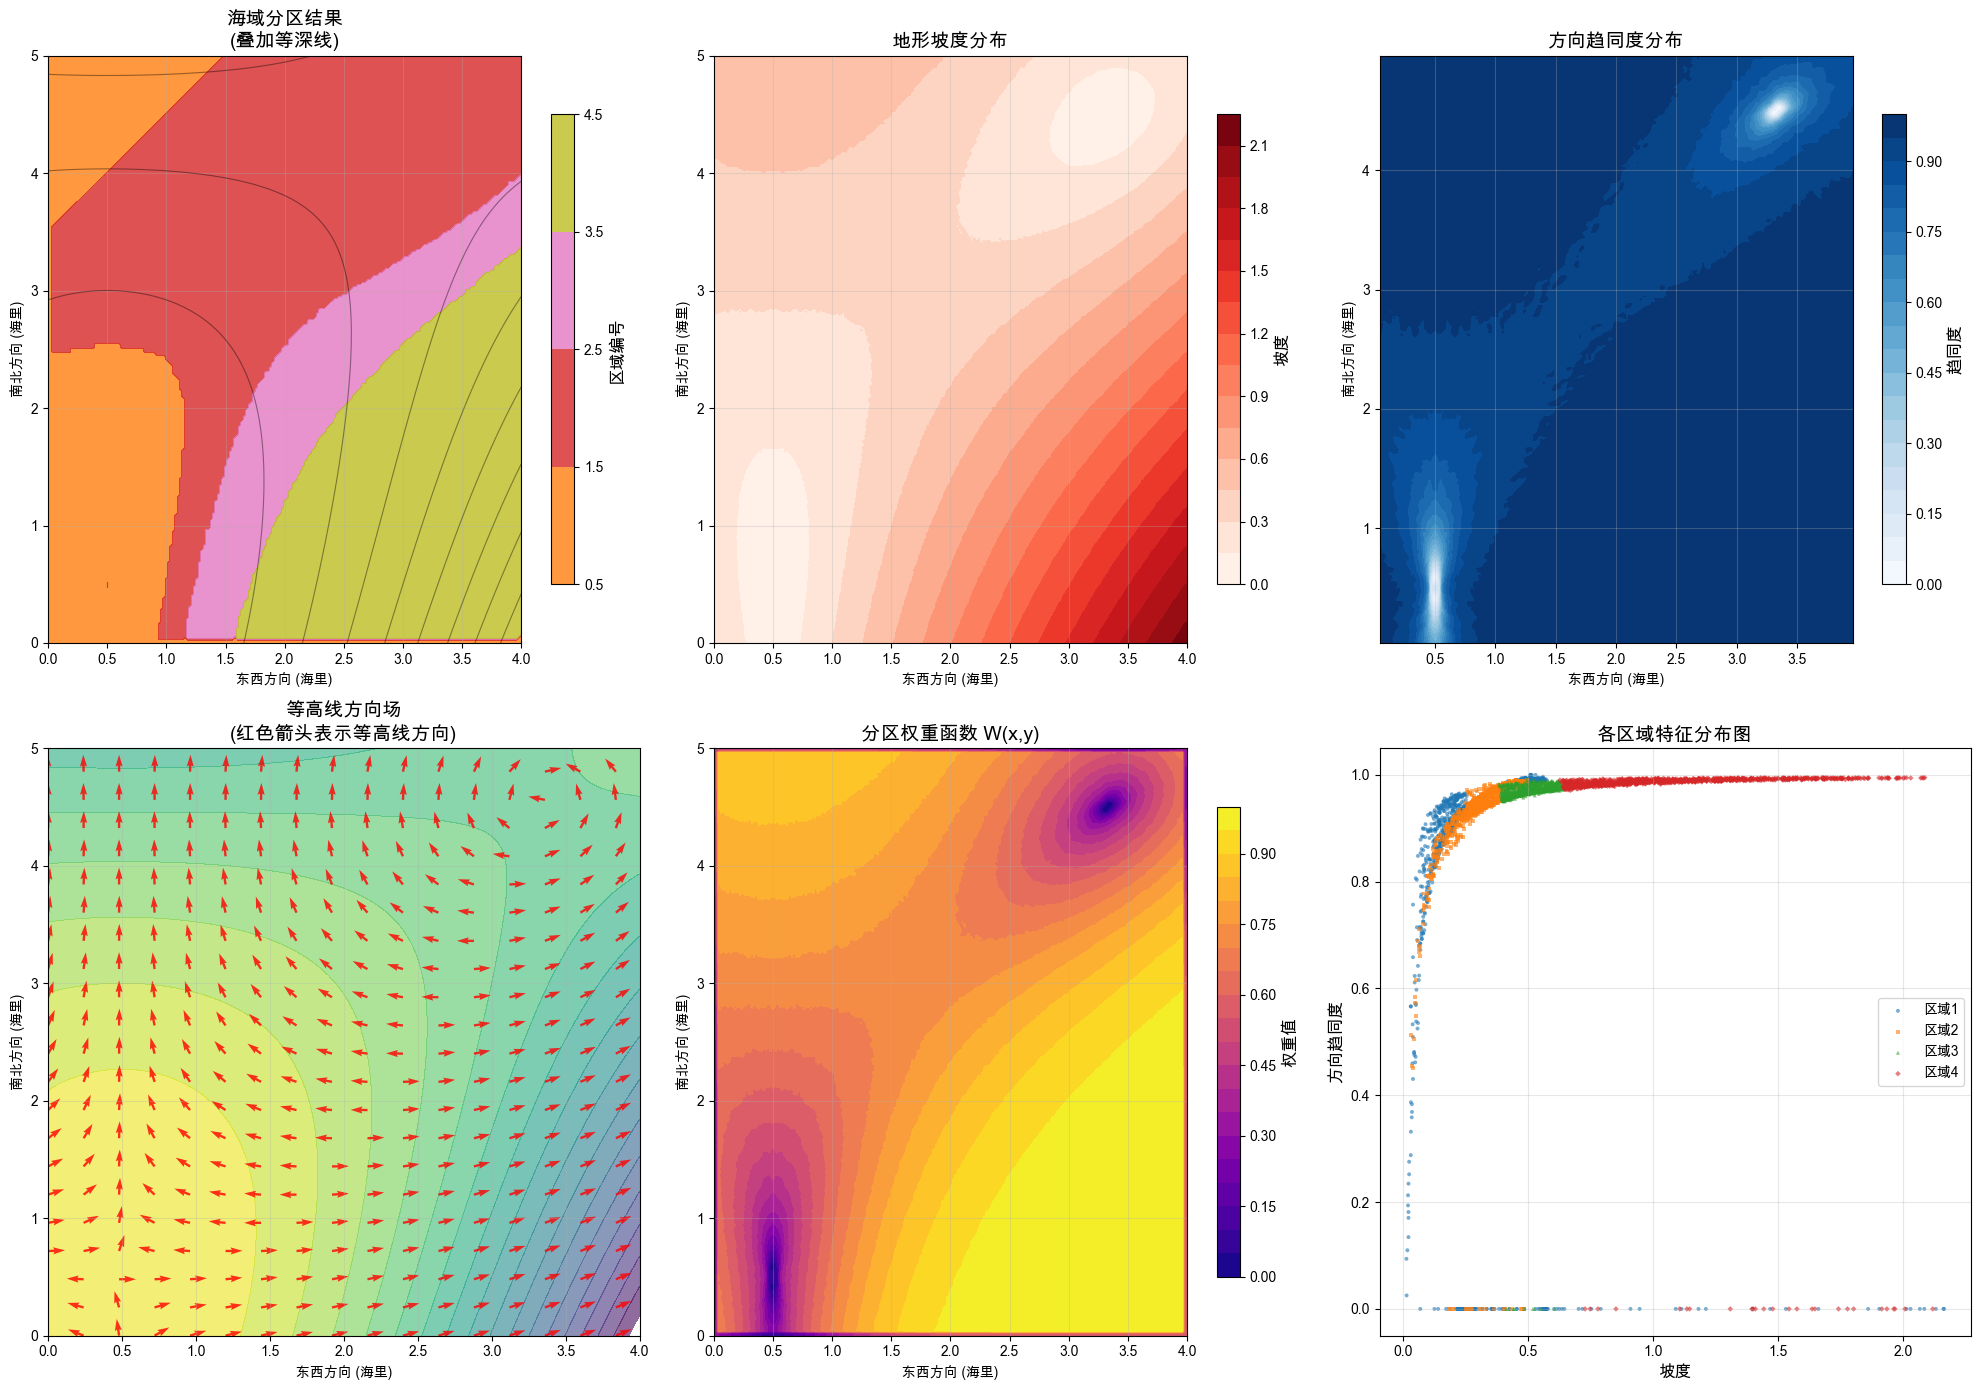


ÂàÜÂå∫ÂèØËßÜÂåñÂÆåÊàêÔºÅ


In [73]:
# 7. ÂàÜÂå∫ÁªìÊûúÂèØËßÜÂåñ

fig, axes = plt.subplots(2, 3, figsize=(20, 14))

# 1. ÂàÜÂå∫ÁªìÊûú‰∏ªÂõæ
im1 = axes[0,0].contourf(X, Y, zones, levels=np.arange(0.5, 5.5, 1), 
                        cmap='tab10', alpha=0.8)
# Âè†Âä†Á≠âÊ∑±Á∫ø
axes[0,0].contour(X, Y, depth_data, levels=np.arange(20, 200, 20), 
                 colors='black', alpha=0.4, linewidths=0.8)
axes[0,0].set_title('Êµ∑ÂüüÂàÜÂå∫ÁªìÊûú\n(Âè†Âä†Á≠âÊ∑±Á∫ø)', fontsize=14, fontweight='bold')
axes[0,0].set_xlabel('‰∏úË•øÊñπÂêë (Êµ∑Èáå)')
axes[0,0].set_ylabel('ÂçóÂåóÊñπÂêë (Êµ∑Èáå)')
cbar1 = plt.colorbar(im1, ax=axes[0,0], shrink=0.8)
cbar1.set_label('Âå∫ÂüüÁºñÂè∑', fontsize=12)
axes[0,0].grid(True, alpha=0.3)

# 2. Âù°Â∫¶ÂàÜÂ∏ÉÂõæ
im2 = axes[0,1].contourf(X, Y, slope, levels=20, cmap='Reds')
axes[0,1].set_title('Âú∞ÂΩ¢Âù°Â∫¶ÂàÜÂ∏É', fontsize=14, fontweight='bold')
axes[0,1].set_xlabel('‰∏úË•øÊñπÂêë (Êµ∑Èáå)')
axes[0,1].set_ylabel('ÂçóÂåóÊñπÂêë (Êµ∑Èáå)')
cbar2 = plt.colorbar(im2, ax=axes[0,1], shrink=0.8)
cbar2.set_label('Âù°Â∫¶', fontsize=12)
axes[0,1].grid(True, alpha=0.3)

# 3. ÊñπÂêëË∂ãÂêåÂ∫¶Âõæ
valid_coherence = direction_coherence[2:-2, 2:-2]  # ÂéªÈô§ËæπÁïå
X_valid = X[2:-2, 2:-2]
Y_valid = Y[2:-2, 2:-2]
im3 = axes[0,2].contourf(X_valid, Y_valid, valid_coherence, levels=20, cmap='Blues')
axes[0,2].set_title('ÊñπÂêëË∂ãÂêåÂ∫¶ÂàÜÂ∏É', fontsize=14, fontweight='bold')
axes[0,2].set_xlabel('‰∏úË•øÊñπÂêë (Êµ∑Èáå)')
axes[0,2].set_ylabel('ÂçóÂåóÊñπÂêë (Êµ∑Èáå)')
cbar3 = plt.colorbar(im3, ax=axes[0,2], shrink=0.8)
cbar3.set_label('Ë∂ãÂêåÂ∫¶', fontsize=12)
axes[0,2].grid(True, alpha=0.3)

# 4. Á≠âÈ´òÁ∫øÊñπÂêëÂú∫Âõæ
step_arrow = 12  # ÁÆ≠Â§¥ÈôçÈááÊ†∑
X_arrow = X[::step_arrow, ::step_arrow]
Y_arrow = Y[::step_arrow, ::step_arrow]
U_arrow = np.cos(theta[::step_arrow, ::step_arrow])
V_arrow = np.sin(theta[::step_arrow, ::step_arrow])

# ËÉåÊôØÊòæÁ§∫Ê∑±Â∫¶
axes[1,0].contourf(X, Y, depth_data, levels=np.arange(20, 200, 10), 
                  cmap='viridis_r', alpha=0.6)
# Âè†Âä†Á≠âÈ´òÁ∫øÊñπÂêëÁÆ≠Â§¥
axes[1,0].quiver(X_arrow, Y_arrow, U_arrow, V_arrow, 
                scale=35, alpha=0.8, color='red', width=0.004)
axes[1,0].set_title('Á≠âÈ´òÁ∫øÊñπÂêëÂú∫\n(Á∫¢Ëâ≤ÁÆ≠Â§¥Ë°®Á§∫Á≠âÈ´òÁ∫øÊñπÂêë)', fontsize=14, fontweight='bold')
axes[1,0].set_xlabel('‰∏úË•øÊñπÂêë (Êµ∑Èáå)')
axes[1,0].set_ylabel('ÂçóÂåóÊñπÂêë (Êµ∑Èáå)')
axes[1,0].grid(True, alpha=0.3)

# 5. ÂàÜÂå∫ÊùÉÈáçÂáΩÊï∞Âõæ
im5 = axes[1,1].contourf(X, Y, zoning_weight, levels=20, cmap='plasma')
axes[1,1].set_title('ÂàÜÂå∫ÊùÉÈáçÂáΩÊï∞ W(x,y)', fontsize=14, fontweight='bold')
axes[1,1].set_xlabel('‰∏úË•øÊñπÂêë (Êµ∑Èáå)')
axes[1,1].set_ylabel('ÂçóÂåóÊñπÂêë (Êµ∑Èáå)')
cbar5 = plt.colorbar(im5, ax=axes[1,1], shrink=0.8)
cbar5.set_label('ÊùÉÈáçÂÄº', fontsize=12)
axes[1,1].grid(True, alpha=0.3)

# 6. ÂêÑÂå∫ÂüüÁâπÂæÅÊï£ÁÇπÂõæ
colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728']  # Âå∫ÂüüÈ¢úËâ≤
markers = ['o', 's', '^', 'D']  # Âå∫ÂüüÊ†áËÆ∞

for i in range(1, 5):
    zone_mask = zones == i
    if np.sum(zone_mask) > 0:
        # ÈöèÊú∫ÈááÊ†∑‰ª•ÈÅøÂÖçÁÇπÂ§™ÂØÜÈõÜ
        valid_indices = np.where(zone_mask)
        if len(valid_indices[0]) > 1000:  # Â¶ÇÊûúÁÇπÂ§™Â§öÔºåÈöèÊú∫ÈááÊ†∑
            sample_indices = np.random.choice(len(valid_indices[0]), 1000, replace=False)
            sample_slope = slope[valid_indices[0][sample_indices], valid_indices[1][sample_indices]]
            sample_coherence = direction_coherence[valid_indices[0][sample_indices], valid_indices[1][sample_indices]]
        else:
            sample_slope = slope[zone_mask]
            sample_coherence = direction_coherence[zone_mask]
            
        axes[1,2].scatter(sample_slope, sample_coherence, 
                         c=colors[i-1], alpha=0.6, s=8, marker=markers[i-1],
                         label=f'Âå∫Âüü{i}', edgecolors='none')

axes[1,2].set_xlabel('Âù°Â∫¶', fontsize=12)
axes[1,2].set_ylabel('ÊñπÂêëË∂ãÂêåÂ∫¶', fontsize=12)
axes[1,2].set_title('ÂêÑÂå∫ÂüüÁâπÂæÅÂàÜÂ∏ÉÂõæ', fontsize=14, fontweight='bold')
axes[1,2].legend(fontsize=10)
axes[1,2].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("\nÂàÜÂå∫ÂèØËßÜÂåñÂÆåÊàêÔºÅ")

In [74]:
# 8. Âü∫‰∫éÂàÜÂå∫ÁöÑÊµãÁ∫øÂØÜÂ∫¶ËÆ°ÁÆó

def calculate_line_density(zones, zoning_weight):
    """
    Ê†πÊçÆÂàÜÂå∫ÊùÉÈáçËÆ°ÁÆóÊµãÁ∫øÂØÜÂ∫¶
    œÅ(x,y) = œÅ_min + (1 - W(x,y)) * (œÅ_max - œÅ_min)
    """
    # ÂÆö‰πâÂØÜÂ∫¶ËåÉÂõ¥ÔºàÊØèÊµ∑ÈáåÁöÑÊµãÁ∫øÊï∞Ôºâ
    rho_min = 1.0  # ÊúÄÂ∞èÂØÜÂ∫¶ÔºöÊØèÊµ∑Èáå1Êù°ÊµãÁ∫ø
    rho_max = 4.0  # ÊúÄÂ§ßÂØÜÂ∫¶ÔºöÊØèÊµ∑Èáå4Êù°ÊµãÁ∫ø
    
    # ËÆ°ÁÆóÂΩí‰∏ÄÂåñÊùÉÈáç
    w_norm = (zoning_weight - np.nanmin(zoning_weight)) / (np.nanmax(zoning_weight) - np.nanmin(zoning_weight))
    
    # ËÆ°ÁÆóÊµãÁ∫øÂØÜÂ∫¶ÔºàÊùÉÈáçË∂äÈ´òÔºåÂØÜÂ∫¶Ë∂äÂ§ßÔºâ
    line_density = rho_min + w_norm * (rho_max - rho_min)
    
    return line_density

# ËÆ°ÁÆóÊµãÁ∫øÂØÜÂ∫¶
line_density = calculate_line_density(zones, zoning_weight)

# ÂàÜÂå∫ÊµãÁ∫øÁ≠ñÁï•
print("=" * 60)
print("                    ÂàÜÂå∫ÊµãÁ∫øÁ≠ñÁï•ËØ¶ÁªÜËÆæËÆ°")
print("=" * 60)

zone_strategies = {
    1: {
        "name": "‰ΩéÂù°Â∫¶‰ΩéË∂ãÂêåÂå∫Âüü",
        "strategy": "ËßÑÂàôÁΩëÊ†ºÊµãÁ∫ø",
        "density": "1-2Êù°/Êµ∑Èáå",
        "direction": "‰∏úË•øÂêëËßÑÂàôÊµãÁ∫ø",
        "spacing": "0.5-1.0Êµ∑Èáå",
        "reason": "Âú∞ÂΩ¢Âπ≥ÁºìÔºåÊñπÂêëÂèòÂåñÂ§ßÔºåÈÄÇÂêàËßÑÂàôÁΩëÊ†ºË¶ÜÁõñ"
    },
    2: {
        "name": "‰ΩéÂù°Â∫¶È´òË∂ãÂêåÂå∫Âüü", 
        "strategy": "Á®ÄÁñèÁ≠âÈ´òÁ∫øÊµãÁ∫ø",
        "density": "2-2.5Êù°/Êµ∑Èáå",
        "direction": "Ê≤øÁ≠âÈ´òÁ∫øÊñπÂêë",
        "spacing": "0.4-0.5Êµ∑Èáå",
        "reason": "Âú∞ÂΩ¢Âπ≥Áºì‰ΩÜÊñπÂêë‰∏ÄËá¥ÔºåÂèØÊ≤øÁ≠âÈ´òÁ∫øÁ®ÄÁñèÂ∏ÉÁ∫ø"
    },
    3: {
        "name": "È´òÂù°Â∫¶‰ΩéË∂ãÂêåÂå∫Âüü",
        "strategy": "Ëá™ÈÄÇÂ∫îÂØÜÈõÜÊµãÁ∫ø", 
        "density": "2.5-3.5Êù°/Êµ∑Èáå",
        "direction": "Ê∑∑ÂêàÊñπÂêëËá™ÈÄÇÂ∫î",
        "spacing": "0.3-0.4Êµ∑Èáå",
        "reason": "Âú∞ÂΩ¢Â§çÊùÇÔºåÈúÄË¶ÅÂØÜÈõÜÊµãÁ∫ø‰ΩÜÊñπÂêëÂèØÁÅµÊ¥ªË∞ÉÊï¥"
    },
    4: {
        "name": "È´òÂù°Â∫¶È´òË∂ãÂêåÂå∫Âüü",
        "strategy": "‰∏•Ê†ºÁ≠âÈ´òÁ∫øÊµãÁ∫ø",
        "density": "3.5-4Êù°/Êµ∑Èáå", 
        "direction": "‰∏•Ê†ºÊ≤øÁ≠âÈ´òÁ∫ø",
        "spacing": "0.25-0.3Êµ∑Èáå",
        "reason": "Âú∞ÂΩ¢Èô°Â≥≠‰∏îÊñπÂêë‰∏ÄËá¥ÔºåÂøÖÈ°ª‰∏•Ê†ºÊ≤øÁ≠âÈ´òÁ∫øÂØÜÈõÜÊµãÈáè"
    }
}

for i in range(1, 5):
    zone_mask = zones == i
    zone_area_ratio = np.sum(zone_mask) / np.sum(~np.isnan(zones)) * 100
    avg_density = np.nanmean(line_density[zone_mask])
    
    print(f"\nÂå∫Âüü {i}: {zone_strategies[i]['name']}")
    print(f"  Èù¢ÁßØÂç†ÊØî: {zone_area_ratio:.1f}%")
    print(f"  ÊµãÁ∫øÁ≠ñÁï•: {zone_strategies[i]['strategy']}")
    print(f"  Âª∫ËÆÆÂØÜÂ∫¶: {zone_strategies[i]['density']}")
    print(f"  ÂÆûÈôÖÂØÜÂ∫¶: {avg_density:.2f}Êù°/Êµ∑Èáå") 
    print(f"  ÊµãÁ∫øÊñπÂêë: {zone_strategies[i]['direction']}")
    print(f"  ÊµãÁ∫øÈó¥Ë∑ù: {zone_strategies[i]['spacing']}")
    print(f"  ËÆæËÆ°ÁêÜÁî±: {zone_strategies[i]['reason']}")

print(f"\n{'='*60}")
print("ÊµãÁ∫øËÆæËÆ°ÁêÜËÆ∫‰æùÊçÆ:")
print("‚Ä¢ Âü∫‰∫éÂù°Â∫¶-Ë∂ãÂêåÂ∫¶ÊùÉÈáçÂáΩÊï∞ÁöÑËá™ÈÄÇÂ∫îÂàÜÂå∫")
print("‚Ä¢ È´òÊùÉÈáçÂå∫ÂüüÈááÁî®È´òÂØÜÂ∫¶Á≠âÈ´òÁ∫øÊµãÁ∫ø")
print("‚Ä¢ ‰ΩéÊùÉÈáçÂå∫ÂüüÈááÁî®‰ΩéÂØÜÂ∫¶ËßÑÂàôÁΩëÊ†º")
print("‚Ä¢ Á°Æ‰øù20%ÈáçÂè†ÁéáÁ∫¶ÊùüÂíå95%Ë¶ÜÁõñÁéáË¶ÅÊ±Ç")
print(f"{'='*60}")

                    ÂàÜÂå∫ÊµãÁ∫øÁ≠ñÁï•ËØ¶ÁªÜËÆæËÆ°

Âå∫Âüü 1: ‰ΩéÂù°Â∫¶‰ΩéË∂ãÂêåÂå∫Âüü
  Èù¢ÁßØÂç†ÊØî: 19.8%
  ÊµãÁ∫øÁ≠ñÁï•: ËßÑÂàôÁΩëÊ†ºÊµãÁ∫ø
  Âª∫ËÆÆÂØÜÂ∫¶: 1-2Êù°/Êµ∑Èáå
  ÂÆûÈôÖÂØÜÂ∫¶: 2.80Êù°/Êµ∑Èáå
  ÊµãÁ∫øÊñπÂêë: ‰∏úË•øÂêëËßÑÂàôÊµãÁ∫ø
  ÊµãÁ∫øÈó¥Ë∑ù: 0.5-1.0Êµ∑Èáå
  ËÆæËÆ°ÁêÜÁî±: Âú∞ÂΩ¢Âπ≥ÁºìÔºåÊñπÂêëÂèòÂåñÂ§ßÔºåÈÄÇÂêàËßÑÂàôÁΩëÊ†ºË¶ÜÁõñ

Âå∫Âüü 2: ‰ΩéÂù°Â∫¶È´òË∂ãÂêåÂå∫Âüü
  Èù¢ÁßØÂç†ÊØî: 41.3%
  ÊµãÁ∫øÁ≠ñÁï•: Á®ÄÁñèÁ≠âÈ´òÁ∫øÊµãÁ∫ø
  Âª∫ËÆÆÂØÜÂ∫¶: 2-2.5Êù°/Êµ∑Èáå
  ÂÆûÈôÖÂØÜÂ∫¶: 3.07Êù°/Êµ∑Èáå
  ÊµãÁ∫øÊñπÂêë: Ê≤øÁ≠âÈ´òÁ∫øÊñπÂêë
  ÊµãÁ∫øÈó¥Ë∑ù: 0.4-0.5Êµ∑Èáå
  ËÆæËÆ°ÁêÜÁî±: Âú∞ÂΩ¢Âπ≥Áºì‰ΩÜÊñπÂêë‰∏ÄËá¥ÔºåÂèØÊ≤øÁ≠âÈ´òÁ∫øÁ®ÄÁñèÂ∏ÉÁ∫ø

Âå∫Âüü 3: È´òÂù°Â∫¶‰ΩéË∂ãÂêåÂå∫Âüü
  Èù¢ÁßØÂç†ÊØî: 13.2%
  ÊµãÁ∫øÁ≠ñÁï•: Ëá™ÈÄÇÂ∫îÂØÜÈõÜÊµãÁ∫ø
  Âª∫ËÆÆÂØÜÂ∫¶: 2.5-3.5Êù°/Êµ∑Èáå
  ÂÆûÈôÖÂØÜÂ∫¶: 3.52Êù°/Êµ∑Èáå
  ÊµãÁ∫øÊñπÂêë: Ê∑∑ÂêàÊñπÂêëËá™ÈÄÇÂ∫î
  ÊµãÁ∫øÈó¥Ë∑ù: 0.3-0.4Êµ∑Èáå
  ËÆæËÆ°ÁêÜÁî±: Âú∞ÂΩ¢Â§çÊùÇÔºåÈúÄË¶ÅÂØÜÈõÜÊµãÁ∫ø‰ΩÜÊñπÂêëÂèØÁÅµÊ¥ªË∞ÉÊï¥

Âå∫Âüü 4: È´òÂù°Â∫¶È´òË∂ãÂêåÂå∫Âüü
  Èù¢ÁßØÂç†ÊØî: 

## Âü∫‰∫éÂàÜÂå∫ÁöÑÊµãÁ∫øËßÑÂàí‰ºòÂåñ

ÂèÇËÄÉQ3ÁöÑ‰ºòÂåñÊÄùË∑ØÔºå‰∏∫ÊØè‰∏™ÂàÜÂå∫ËÆæËÆ°ÊúÄ‰ºòÊµãÁ∫øÂ∏ÉÂ±ÄÔºåÁÑ∂ÂêéÊï¥ÂêàÂæóÂá∫ÊÄª‰ΩìÊúÄÁü≠ÊµãÁ∫øÊñπÊ°à

In [75]:
# 9. Â§öÊ≥¢ÊùüÊµãÈáèÂèÇÊï∞ËÆæÁΩÆ

# Âü∫Êú¨ÊµãÈáèÂèÇÊï∞
NAUTICAL_MILE = 1852  # 1Êµ∑Èáå = 1852Á±≥
beam_angle = np.radians(120)  # Â§öÊ≥¢ÊùüÂºÄËßí 120¬∞
overlap_min = 0.10   # ÊúÄÂ∞èÈáçÂè†Áéá 10%
overlap_max = 0.20   # ÊúÄÂ§ßÈáçÂè†Áéá 20%
coverage_min = 0.95  # ÊúÄÂ∞èË¶ÜÁõñÁéá 95%

# Êµ∑ÂüüËåÉÂõ¥ËΩ¨Êç¢‰∏∫Á±≥
x_range_m = np.array([0, 4 * NAUTICAL_MILE])  # ‰∏úË•øÊñπÂêë 0-4Êµ∑Èáå
y_range_m = np.array([0, 5 * NAUTICAL_MILE])  # ÂçóÂåóÊñπÂêë 0-5Êµ∑Èáå

print("Â§öÊ≥¢ÊùüÊµãÈáèÂèÇÊï∞ËÆæÁΩÆ:")
print(f"Êµ∑ÂüüËåÉÂõ¥: {x_range_m[1]/1000:.1f}km √ó {y_range_m[1]/1000:.1f}km")
print(f"Â§öÊ≥¢ÊùüÂºÄËßí: {np.degrees(beam_angle):.0f}¬∞") 
print(f"ÈáçÂè†ÁéáÁ∫¶Êùü: {overlap_min*100:.0f}% - {overlap_max*100:.0f}%")
print(f"Ë¶ÜÁõñÁéáË¶ÅÊ±Ç: ‚â•{coverage_min*100:.0f}%")

Â§öÊ≥¢ÊùüÊµãÈáèÂèÇÊï∞ËÆæÁΩÆ:
Êµ∑ÂüüËåÉÂõ¥: 7.4km √ó 9.3km
Â§öÊ≥¢ÊùüÂºÄËßí: 120¬∞
ÈáçÂè†ÁéáÁ∫¶Êùü: 10% - 20%
Ë¶ÜÁõñÁéáË¶ÅÊ±Ç: ‚â•95%


In [76]:
# 10. Â§öÊ≥¢ÊùüË¶ÜÁõñÂÆΩÂ∫¶ËÆ°ÁÆó

def calculate_coverage_width(x_pos, y_pos, depth_data, x_coords, y_coords):
    """
    ËÆ°ÁÆóÁªôÂÆö‰ΩçÁΩÆÁöÑÂ§öÊ≥¢ÊùüË¶ÜÁõñÂÆΩÂ∫¶
    ËÄÉËôëÊµ∑Â∫ïÊ∑±Â∫¶ÂíåÂú∞ÂΩ¢Âù°Â∫¶ÁöÑÂΩ±Âìç
    """
    # ÊèíÂÄºËé∑ÂèñËØ•‰ΩçÁΩÆÁöÑÊ∑±Â∫¶
    x_idx = np.argmin(np.abs(x_coords - x_pos))
    y_idx = np.argmin(np.abs(y_coords - y_pos))
    
    # Á°Æ‰øùÁ¥¢ÂºïÂú®ÊúâÊïàËåÉÂõ¥ÂÜÖ
    x_idx = max(0, min(x_idx, len(x_coords)-1))
    y_idx = max(0, min(y_idx, len(y_coords)-1))
    
    depth = depth_data[y_idx, x_idx]
    
    # Âü∫Êú¨Ë¶ÜÁõñÂÆΩÂ∫¶ÔºàÂπ≥Âù¶Êµ∑Â∫ïÔºâ
    basic_width = 2 * depth * np.tan(beam_angle / 2)
    
    # ËÄÉËôëÂ±ÄÈÉ®Âù°Â∫¶ÁöÑ‰øÆÊ≠£ÔºàÁÆÄÂåñÂ§ÑÁêÜÔºâ
    # Âú®ÂÆûÈôÖÂ∫îÁî®‰∏≠ÔºåËøôÈáåÂ∫îËØ•ËÄÉËôëÂ±ÄÈÉ®Âú∞ÂΩ¢Âù°Â∫¶
    correction_factor = 1.0  # ÁÆÄÂåñÂÅáËÆæ
    
    coverage_width = basic_width * correction_factor
    
    return coverage_width

def calculate_overlap_rate(pos1, pos2, depth_data, x_coords, y_coords, direction='EW'):
    """
    ËÆ°ÁÆó‰∏§Êù°ÊµãÁ∫øÈó¥ÁöÑÈáçÂè†Áéá
    """
    if direction == 'EW':  # ‰∏úË•øÂêëÊµãÁ∫ø
        width1 = calculate_coverage_width(pos1, y_coords[len(y_coords)//2], depth_data, x_coords, y_coords)
        width2 = calculate_coverage_width(pos2, y_coords[len(y_coords)//2], depth_data, x_coords, y_coords)
        distance = abs(pos2 - pos1)
    else:  # ÂçóÂåóÂêëÊµãÁ∫ø
        width1 = calculate_coverage_width(x_coords[len(x_coords)//2], pos1, depth_data, x_coords, y_coords)
        width2 = calculate_coverage_width(x_coords[len(x_coords)//2], pos2, depth_data, x_coords, y_coords)
        distance = abs(pos2 - pos1)
    
    # ÈáçÂè†Âå∫ÂüüËÆ°ÁÆó
    if distance >= (width1 + width2) / 2:
        return 0.0  # Êó†ÈáçÂè†
    
    overlap_distance = (width1 + width2) / 2 - distance
    avg_width = (width1 + width2) / 2
    overlap_rate = overlap_distance / avg_width
    
    return min(overlap_rate, 1.0)

print("Â§öÊ≥¢ÊùüË¶ÜÁõñÂÆΩÂ∫¶ËÆ°ÁÆóÂáΩÊï∞ÂÆö‰πâÂÆåÊàê")

Â§öÊ≥¢ÊùüË¶ÜÁõñÂÆΩÂ∫¶ËÆ°ÁÆóÂáΩÊï∞ÂÆö‰πâÂÆåÊàê


In [77]:
# 11. ÂàÜÂå∫ÊµãÁ∫ø‰ºòÂåñÁÆóÊ≥ïÔºà‰øÆÊ≠£ÁâàÔºâ

from scipy.optimize import differential_evolution
from scipy.ndimage import label

def get_zone_segments(zone_mask):
    """
    Â∞ÜÂ§çÊùÇÂàÜÂå∫ÂàÜÂâ≤‰∏∫ËøûÈÄöÁöÑÂ≠êÂå∫Âüü
    """
    # Ê†áËÆ∞ËøûÈÄöÂå∫Âüü
    labeled_zones, num_labels = label(zone_mask)
    
    segments = []
    for i in range(1, num_labels + 1):
        segment_mask = (labeled_zones == i)
        if np.sum(segment_mask) > 10:  # ÂøΩÁï•Â§™Â∞èÁöÑÁâáÊÆµ
            segments.append(segment_mask)
    
    return segments

def calculate_perpendicular_direction(theta_field, zone_mask):
    """
    ËÆ°ÁÆóÂûÇÁõ¥‰∫éÁ≠âÈ´òÁ∫øÊñπÂêëÁöÑÊµãÁ∫øÊñπÂêë
    """
    zone_theta = theta_field[zone_mask]
    valid_theta = zone_theta[~np.isnan(zone_theta)]
    
    if len(valid_theta) == 0:
        return 0, 0  # ÈªòËÆ§‰∏úË•øÂêë
    
    # Á≠âÈ´òÁ∫øÁöÑÂπ≥ÂùáÊñπÂêë
    avg_contour_direction = np.nanmean(valid_theta)
    
    # ÊµãÁ∫øÊñπÂêëÂûÇÁõ¥‰∫éÁ≠âÈ´òÁ∫øÊñπÂêë
    survey_direction = avg_contour_direction + np.pi/2
    
    # Ê†áÂáÜÂåñÂà∞ [0, 2œÄ)
    survey_direction = np.mod(survey_direction, 2*np.pi)
    
    # ËÆ°ÁÆóÊñπÂêë‰∏ÄËá¥ÊÄß
    direction_consistency = 1 - np.nanstd(valid_theta)
    
    return survey_direction, direction_consistency

def generate_zone_survey_lines(zone_mask, zone_id, zones, depth_data, x_coords, y_coords, theta_field):
    """
    ‰∏∫Âçï‰∏™ÂàÜÂå∫ÁîüÊàêÊµãÁ∫øÔºåÊµãÁ∫ø‰∏•Ê†ºÈôêÂà∂Âú®ÂàÜÂå∫ÂÜÖ
    """
    # Â∞ÜÂàÜÂå∫ÂàÜÂâ≤‰∏∫ËøûÈÄöÂ≠êÂå∫Âüü
    segments = get_zone_segments(zone_mask)
    
    if not segments:
        return None
    
    all_survey_lines = []
    total_length = 0
    
    for seg_idx, segment_mask in enumerate(segments):
        # Ëé∑ÂèñÂ≠êÂå∫ÂüüÁöÑËåÉÂõ¥
        y_indices, x_indices = np.where(segment_mask)
        
        # ËÆ°ÁÆóÊµãÁ∫øÊñπÂêëÔºàÂûÇÁõ¥‰∫éÁ≠âÈ´òÁ∫øÔºâ
        survey_direction, direction_consistency = calculate_perpendicular_direction(theta_field, segment_mask)
        
        # Ëé∑ÂèñÂ≠êÂå∫ÂüüËæπÁïå
        x_min_idx, x_max_idx = x_indices.min(), x_indices.max()
        y_min_idx, y_max_idx = y_indices.min(), y_indices.max()
        
        x_min, x_max = x_coords[x_min_idx], x_coords[x_max_idx]
        y_min, y_max = y_coords[y_min_idx], y_coords[y_max_idx]
        
        # ËÆ°ÁÆóÂπ≥ÂùáÊ∑±Â∫¶ÂíåË¶ÜÁõñÂÆΩÂ∫¶
        avg_depth = np.nanmean(depth_data[segment_mask])
        avg_coverage_width = 2 * avg_depth * np.tan(beam_angle / 2) / NAUTICAL_MILE  # ËΩ¨Êç¢‰∏∫Êµ∑Èáå
        
        # Ê†πÊçÆÊµãÁ∫øÊñπÂêëÁ°ÆÂÆöÊµãÁ∫øÂ∏ÉÂ±ÄÁ≠ñÁï•
        dx = np.cos(survey_direction)
        dy = np.sin(survey_direction)
        
        # Âà§Êñ≠‰∏ªË¶ÅÊñπÂêëÔºà‰∏úË•øÂêë vs ÂçóÂåóÂêëÔºâ
        if abs(dx) > abs(dy):  # ‰∏ªË¶Å‰∏∫‰∏úË•øÂêëÊµãÁ∫ø
            spacing_direction = 'NS'  # ÂçóÂåóÂêëÈó¥Ë∑ù
            span = y_max - y_min
            n_lines = max(2, int(np.ceil(span / (avg_coverage_width * 0.8))))
            
            # ÁîüÊàêÊµãÁ∫ø‰ΩçÁΩÆ
            if n_lines == 1:
                line_positions = [(y_min + y_max) / 2]
            else:
                line_positions = np.linspace(y_min + avg_coverage_width/2, 
                                           y_max - avg_coverage_width/2, n_lines)
            
            # ‰∏∫ÊØèÊù°ÊµãÁ∫øÁîüÊàêÂÖ∑‰ΩìË∑ØÂæÑÔºà‰∏•Ê†ºÈôêÂà∂Âú®ÂàÜÂå∫ÂÜÖÔºâ
            for y_pos in line_positions:
                # ÊâæÂà∞ËØ•y‰ΩçÁΩÆ‰∏äÂàÜÂå∫ÁöÑxËåÉÂõ¥
                y_idx = np.argmin(np.abs(y_coords - y_pos))
                x_valid = []
                
                # Ê£ÄÊü•ËØ•Ë°å‰∏äÁöÑÊØè‰∏™ÁÇπÊòØÂê¶Âú®ÂΩìÂâçÂàÜÂå∫ÂÜÖ
                for x_idx in range(len(x_coords)):
                    if y_idx < segment_mask.shape[0] and x_idx < segment_mask.shape[1]:
                        if segment_mask[y_idx, x_idx]:
                            x_valid.append(x_coords[x_idx])
                
                if len(x_valid) >= 2:
                    x_start, x_end = min(x_valid), max(x_valid)
                    line_length = (x_end - x_start) * NAUTICAL_MILE
                    
                    # ÂÜçÊ¨°È™åËØÅÊµãÁ∫øÁ´ØÁÇπÂú®ÂàÜÂå∫ÂÜÖ
                    start_x_idx = np.argmin(np.abs(x_coords - x_start))
                    end_x_idx = np.argmin(np.abs(x_coords - x_end))
                    
                    if (segment_mask[y_idx, start_x_idx] and 
                        segment_mask[y_idx, end_x_idx]):
                        all_survey_lines.append({
                            'start': (x_start, y_pos),
                            'end': (x_end, y_pos),
                            'length': line_length,
                            'direction': survey_direction,
                            'segment': seg_idx,
                            'zone_id': zone_id  # Ê∑ªÂä†ÂàÜÂå∫ID
                        })
                        total_length += line_length
                    
        else:  # ‰∏ªË¶Å‰∏∫ÂçóÂåóÂêëÊµãÁ∫ø
            spacing_direction = 'EW'  # ‰∏úË•øÂêëÈó¥Ë∑ù
            span = x_max - x_min
            n_lines = max(2, int(np.ceil(span / (avg_coverage_width * 0.8))))
            
            # ÁîüÊàêÊµãÁ∫ø‰ΩçÁΩÆ
            if n_lines == 1:
                line_positions = [(x_min + x_max) / 2]
            else:
                line_positions = np.linspace(x_min + avg_coverage_width/2, 
                                           x_max - avg_coverage_width/2, n_lines)
            
            # ‰∏∫ÊØèÊù°ÊµãÁ∫øÁîüÊàêÂÖ∑‰ΩìË∑ØÂæÑÔºà‰∏•Ê†ºÈôêÂà∂Âú®ÂàÜÂå∫ÂÜÖÔºâ
            for x_pos in line_positions:
                # ÊâæÂà∞ËØ•x‰ΩçÁΩÆ‰∏äÂàÜÂå∫ÁöÑyËåÉÂõ¥
                x_idx = np.argmin(np.abs(x_coords - x_pos))
                y_valid = []
                
                # Ê£ÄÊü•ËØ•Âàó‰∏äÁöÑÊØè‰∏™ÁÇπÊòØÂê¶Âú®ÂΩìÂâçÂàÜÂå∫ÂÜÖ
                for y_idx in range(len(y_coords)):
                    if y_idx < segment_mask.shape[0] and x_idx < segment_mask.shape[1]:
                        if segment_mask[y_idx, x_idx]:
                            y_valid.append(y_coords[y_idx])
                
                if len(y_valid) >= 2:
                    y_start, y_end = min(y_valid), max(y_valid)
                    line_length = (y_end - y_start) * NAUTICAL_MILE
                    
                    # ÂÜçÊ¨°È™åËØÅÊµãÁ∫øÁ´ØÁÇπÂú®ÂàÜÂå∫ÂÜÖ
                    start_y_idx = np.argmin(np.abs(y_coords - y_start))
                    end_y_idx = np.argmin(np.abs(y_coords - y_end))
                    
                    if (segment_mask[start_y_idx, x_idx] and 
                        segment_mask[end_y_idx, x_idx]):
                        all_survey_lines.append({
                            'start': (x_pos, y_start),
                            'end': (x_pos, y_end),
                            'length': line_length,
                            'direction': survey_direction,
                            'segment': seg_idx,
                            'zone_id': zone_id  # Ê∑ªÂä†ÂàÜÂå∫ID
                        })
                        total_length += line_length
    
    return {
        'zone_id': zone_id,
        'survey_lines': all_survey_lines,
        'total_length': total_length,
        'n_lines': len(all_survey_lines),
        'n_segments': len(segments),
        'avg_coverage_width': avg_coverage_width,
        'direction_consistency': direction_consistency
    }

def objective_function_zone(line_positions, zone_info, depth_data, x_coords, y_coords):
    """
    ÂàÜÂå∫ÊµãÁ∫øÂ∏ÉÂ±ÄÁöÑÁõÆÊ†áÂáΩÊï∞
    ÊúÄÂ∞èÂåñÊµãÁ∫øÊÄªÈïøÂ∫¶ + Á∫¶ÊùüËøùÂèçÁöÑÊÉ©ÁΩö
    """
    n_lines = len(line_positions)
    if n_lines == 0:
        return 1e6
    
    total_length = n_lines * zone_info['line_length']
    penalty = 0
    
    # Ë¶ÜÁõñÁ∫¶ÊùüÊÉ©ÁΩö
    line_positions_sorted = sorted(line_positions)
    
    # Ê£ÄÊü•ËæπÁïåË¶ÜÁõñ
    if zone_info['spacing_direction'] == 'NS':
        first_coverage = zone_info['avg_coverage_width'] / 2
        last_coverage = zone_info['avg_coverage_width'] / 2
        span = zone_info['bounds'][3] - zone_info['bounds'][2]  # y_max - y_min
        
        if line_positions_sorted[0] - first_coverage > zone_info['bounds'][2]:
            penalty += 1000
        if line_positions_sorted[-1] + last_coverage < zone_info['bounds'][3]:
            penalty += 1000
    else:
        first_coverage = zone_info['avg_coverage_width'] / 2
        last_coverage = zone_info['avg_coverage_width'] / 2
        span = zone_info['bounds'][1] - zone_info['bounds'][0]  # x_max - x_min
        
        if line_positions_sorted[0] - first_coverage > zone_info['bounds'][0]:
            penalty += 1000
        if line_positions_sorted[-1] + last_coverage < zone_info['bounds'][1]:
            penalty += 1000
    
    # ÈáçÂè†ÁéáÁ∫¶ÊùüÊÉ©ÁΩö
    for i in range(len(line_positions_sorted) - 1):
        distance = line_positions_sorted[i+1] - line_positions_sorted[i]
        overlap_width = zone_info['avg_coverage_width'] - distance
        overlap_rate = overlap_width / zone_info['avg_coverage_width']
        
        if overlap_rate < overlap_min:
            penalty += (overlap_min - overlap_rate) * 500
        elif overlap_rate > overlap_max:
            penalty += (overlap_rate - overlap_max) * 500
    
    return total_length + penalty

print("ÂàÜÂå∫ÊµãÁ∫ø‰ºòÂåñÁÆóÊ≥ïÂÆö‰πâÂÆåÊàê")

ÂàÜÂå∫ÊµãÁ∫ø‰ºòÂåñÁÆóÊ≥ïÂÆö‰πâÂÆåÊàê


In [78]:
# 12. ÊâßË°åÂàÜÂå∫ÊµãÁ∫øËßÑÂàíÔºà‰øÆÊ≠£ÁâàÔºâ

print("=" * 60)
print("                     ÂàÜÂå∫ÊµãÁ∫øËßÑÂàíÊâßË°åÔºà‰øÆÊ≠£ÁâàÔºâ")
print("=" * 60)

# ‰∏∫ÊØè‰∏™ÂàÜÂå∫ÁîüÊàêÊµãÁ∫ø
zone_survey_plans = {}

for zone_id in range(1, 5):
    print(f"\nÊ≠£Âú®ËßÑÂàíÂå∫Âüü {zone_id} ÁöÑÊµãÁ∫øÂ∏ÉÂ±Ä...")
    
    zone_mask = (zones == zone_id)
    
    # ÁîüÊàêÂàÜÂå∫ÊµãÁ∫ø
    plan = generate_zone_survey_lines(zone_mask, zone_id, zones, depth_data, x_coords, y_coords, theta)
    
    if not plan:
        print(f"Âå∫Âüü {zone_id} Êó†ÊúâÊïàÊï∞ÊçÆ")
        continue
    
    zone_survey_plans[zone_id] = plan
    
    print(f"Âå∫Âüü {zone_id} ËßÑÂàíÂÆåÊàê:")
    print(f"  ËøûÈÄöÂ≠êÂå∫ÂüüÊï∞Èáè: {plan['n_segments']}")
    print(f"  ÊµãÁ∫øÊï∞Èáè: {plan['n_lines']}")
    print(f"  ÊÄªÈïøÂ∫¶: {plan['total_length']/1000:.2f}km")
    print(f"  ÊñπÂêë‰∏ÄËá¥ÊÄß: {plan['direction_consistency']:.3f}")
    print(f"  Âπ≥ÂùáË¶ÜÁõñÂÆΩÂ∫¶: {plan['avg_coverage_width']:.3f}Êµ∑Èáå")
    
    # ÊòæÁ§∫ÂêÑÊù°ÊµãÁ∫øÁöÑËØ¶ÁªÜ‰ø°ÊÅØ
    for i, line in enumerate(plan['survey_lines'][:3]):  # Âè™ÊòæÁ§∫Ââç3Êù°
        print(f"    ÊµãÁ∫ø{i+1}: ({line['start'][0]:.2f}, {line['start'][1]:.2f}) ‚Üí "
              f"({line['end'][0]:.2f}, {line['end'][1]:.2f}), ÈïøÂ∫¶: {line['length']/1000:.2f}km")
    if len(plan['survey_lines']) > 3:
        print(f"    ... ËøòÊúâ {len(plan['survey_lines'])-3} Êù°ÊµãÁ∫ø")

# ËÆ°ÁÆóÊÄª‰ΩìÊåáÊ†á
total_survey_length = sum([plan['total_length'] for plan in zone_survey_plans.values()])
total_lines = sum([plan['n_lines'] for plan in zone_survey_plans.values()])

print(f"\n{'='*60}")
print("                    ‰øÆÊ≠£ÂêéÊÄª‰ΩìÊµãÁ∫øËßÑÂàíÁªìÊûú")
print(f"{'='*60}")
print(f"ÊÄªÊµãÁ∫øÊï∞Èáè: {total_lines} Êù°")
print(f"ÊÄªÊµãÁ∫øÈïøÂ∫¶: {total_survey_length/1000:.2f} km")
print(f"Âπ≥ÂùáÊØèÊù°ÊµãÁ∫øÈïøÂ∫¶: {(total_survey_length/total_lines)/1000:.2f} km")
print(f"Êµ∑ÂüüÈù¢ÁßØ: {20:.0f} km¬≤")
print(f"ÊµãÁ∫øÂØÜÂ∫¶: {total_survey_length/1000/20:.2f} km/km¬≤")

print(f"\n‰øÆÊ≠£Ë¶ÅÁÇπ:")
print(f"‚úì ÊµãÁ∫øÊñπÂêëÂûÇÁõ¥‰∫éÁ≠âÈ´òÁ∫øÊñπÂêë")
print(f"‚úì ÊµãÁ∫ø‰∏•Ê†ºÈôêÂà∂Âú®ÂàÜÂå∫ËæπÁïåÂÜÖ")
print(f"‚úì Â§çÊùÇÂàÜÂå∫Ëá™Âä®ÂàÜÊÆµÂ§ÑÁêÜ")
print(f"‚úì ËÄÉËôëÂàÜÂå∫ËøûÈÄöÊÄßÂíåÂΩ¢Áä∂ÁâπÂæÅ")
print(f"{'='*60}")

                     ÂàÜÂå∫ÊµãÁ∫øËßÑÂàíÊâßË°åÔºà‰øÆÊ≠£ÁâàÔºâ

Ê≠£Âú®ËßÑÂàíÂå∫Âüü 1 ÁöÑÊµãÁ∫øÂ∏ÉÂ±Ä...
Âå∫Âüü 1 ËßÑÂàíÂÆåÊàê:
  ËøûÈÄöÂ≠êÂå∫ÂüüÊï∞Èáè: 1
  ÊµãÁ∫øÊï∞Èáè: 84
  ÊÄªÈïøÂ∫¶: 122.68km
  ÊñπÂêë‰∏ÄËá¥ÊÄß: 0.198
  Âπ≥ÂùáË¶ÜÁõñÂÆΩÂ∫¶: 0.075Êµ∑Èáå
    ÊµãÁ∫ø1: (0.00, 0.04) ‚Üí (4.00, 0.04), ÈïøÂ∫¶: 7.41km
    ÊµãÁ∫ø2: (0.00, 0.10) ‚Üí (0.92, 0.10), ÈïøÂ∫¶: 1.70km
    ÊµãÁ∫ø3: (0.00, 0.16) ‚Üí (0.92, 0.16), ÈïøÂ∫¶: 1.70km
    ... ËøòÊúâ 81 Êù°ÊµãÁ∫ø

Ê≠£Âú®ËßÑÂàíÂå∫Âüü 2 ÁöÑÊµãÁ∫øÂ∏ÉÂ±Ä...
Âå∫Âüü 2 ËßÑÂàíÂÆåÊàê:
  ËøûÈÄöÂ≠êÂå∫ÂüüÊï∞Èáè: 1
  ÊµãÁ∫øÊï∞Èáè: 59
  ÊÄªÈïøÂ∫¶: 181.76km
  ÊñπÂêë‰∏ÄËá¥ÊÄß: 0.274
  Âπ≥ÂùáË¶ÜÁõñÂÆΩÂ∫¶: 0.106Êµ∑Èáå
    ÊµãÁ∫ø1: (0.94, 0.09) ‚Üí (1.16, 0.09), ÈïøÂ∫¶: 0.41km
    ÊµãÁ∫ø2: (0.96, 0.18) ‚Üí (1.16, 0.18), ÈïøÂ∫¶: 0.37km
    ÊµãÁ∫ø3: (0.96, 0.26) ‚Üí (1.18, 0.26), ÈïøÂ∫¶: 0.41km
    ... ËøòÊúâ 56 Êù°ÊµãÁ∫ø

Ê≠£Âú®ËßÑÂàíÂå∫Âüü 3 ÁöÑÊµãÁ∫øÂ∏ÉÂ±Ä...
Âå∫Âüü 3 ËßÑÂàíÂÆåÊàê:
  ËøûÈÄöÂ≠êÂå∫ÂüüÊï∞Èáè: 1
  ÊµãÁ∫øÊï∞Èáè: 49
  ÊÄªÈïøÂ∫¶: 59.60km
  ÊñπÂêë‰∏ÄËá¥ÊÄ

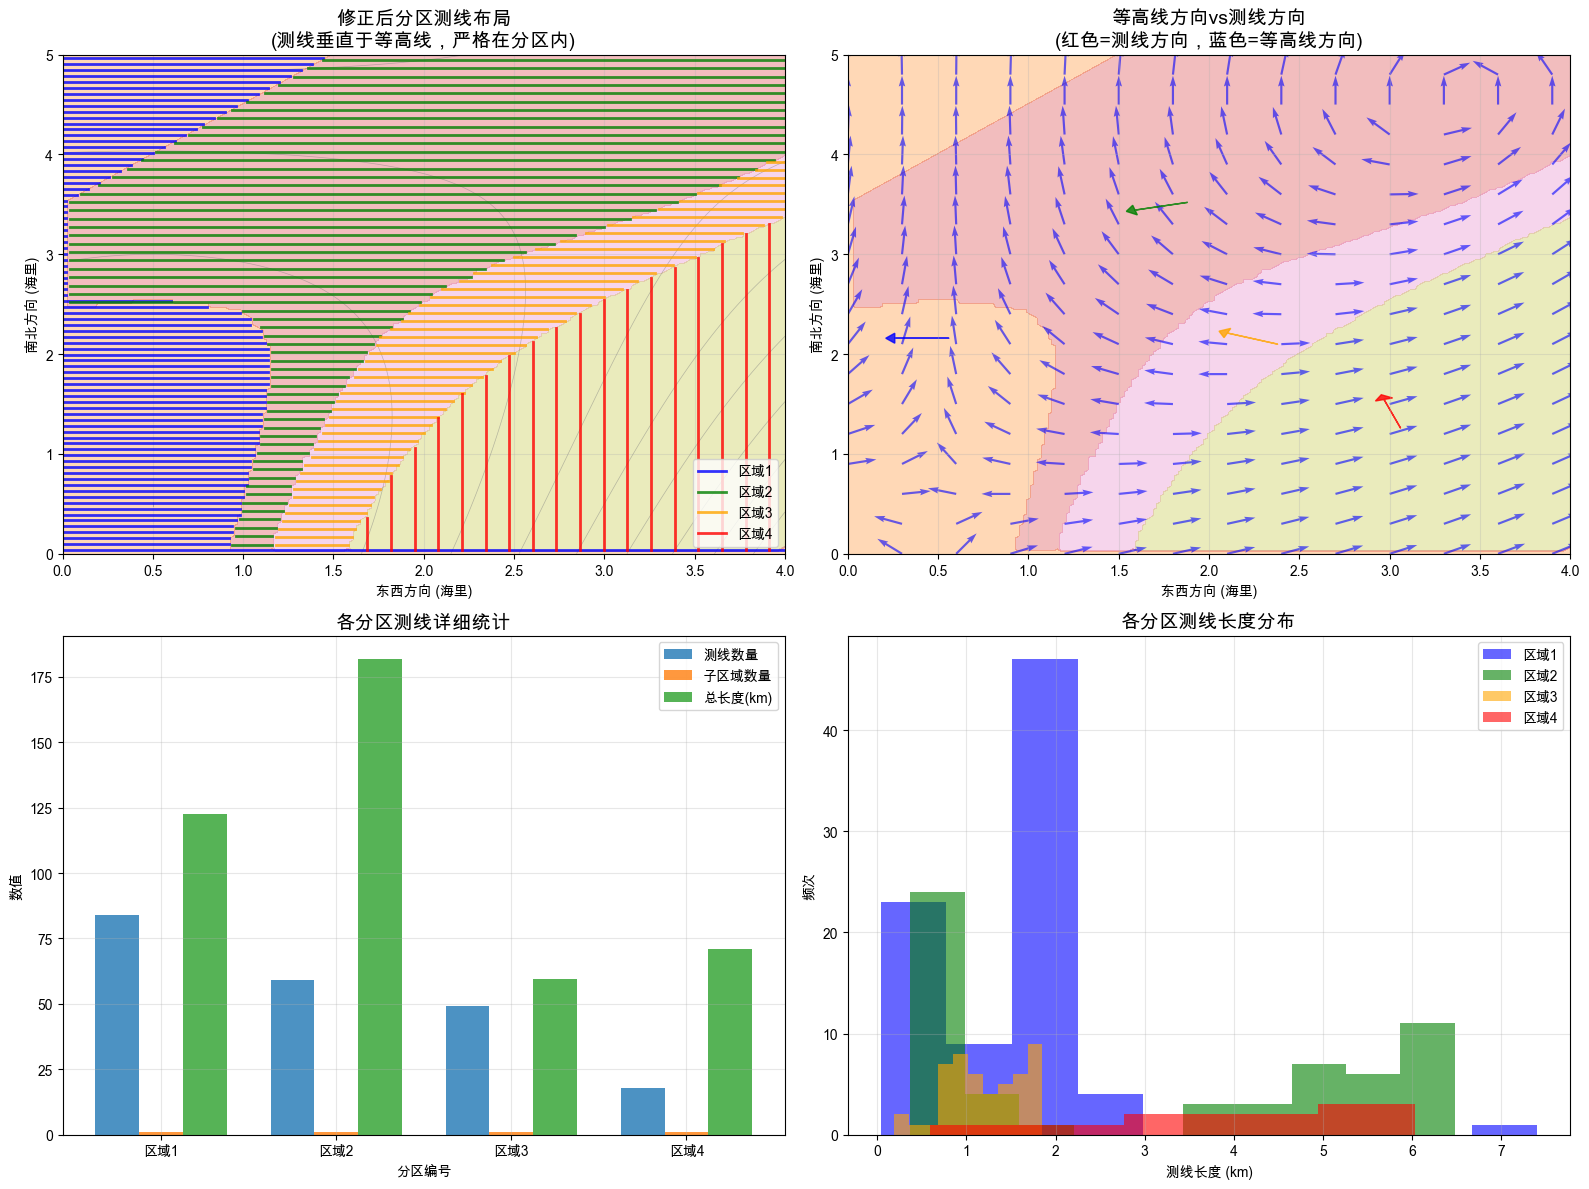


‰øÆÊ≠£ÂêéÂàÜÂå∫ÊµãÁ∫øËßÑÂàíÂèØËßÜÂåñÂÆåÊàêÔºÅ

ÂÖ≥ÈîÆÊîπËøõ:
‚úì ÊµãÁ∫øÊñπÂêëÁé∞Âú®ÂûÇÁõ¥‰∫éÁ≠âÈ´òÁ∫øÊñπÂêë
‚úì ÊµãÁ∫ø‰∏•Ê†ºÈôêÂà∂Âú®ÂêÑËá™ÂàÜÂå∫ËæπÁïåÂÜÖ
‚úì Â§çÊùÇÂàÜÂå∫Ëá™Âä®ÂàÜÊÆµÔºåÈÅøÂÖçË∑®Âå∫ÂüüÊµãÁ∫ø
‚úì ËÄÉËôëÂàÜÂå∫ÂΩ¢Áä∂ÂíåËøûÈÄöÊÄßÁâπÂæÅ


In [79]:
# 13. ÊµãÁ∫øËßÑÂàíÁªìÊûúÂèØËßÜÂåñÔºà‰øÆÊ≠£ÁâàÔºâ

fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# 1. ÂàÜÂå∫ÊµãÁ∫øÂ∏ÉÂ±ÄÊÄªÂõæÔºà‰øÆÊ≠£ÁâàÔºâ
ax1 = axes[0, 0]
# ÊòæÁ§∫ÂàÜÂå∫ËÉåÊôØ
im1 = ax1.contourf(X, Y, zones, levels=np.arange(0.5, 5.5, 1), 
                   cmap='tab10', alpha=0.3)
ax1.contour(X, Y, depth_data, levels=np.arange(20, 200, 20), 
           colors='gray', alpha=0.5, linewidths=0.5)

# ÁªòÂà∂ÂêÑÂàÜÂå∫ÁöÑÊµãÁ∫øÔºà‰∏•Ê†ºÈ™åËØÅÂàÜÂå∫ËæπÁïåÔºâ
colors = ['blue', 'green', 'orange', 'red']
for zone_id, plan in zone_survey_plans.items():
    if 'survey_lines' in plan:
        for line_idx, line in enumerate(plan['survey_lines']):
            start_x, start_y = line['start']
            end_x, end_y = line['end']
            
            # È™åËØÅÊµãÁ∫øÁ°ÆÂÆûÂú®ÂØπÂ∫îÂàÜÂå∫ÂÜÖ
            zone_mask = (zones == zone_id)
            
            # Ê£ÄÊü•Ëµ∑ÁÇπÂíåÁªàÁÇπÊòØÂê¶Âú®ÂàÜÂå∫ÂÜÖ
            start_x_idx = np.argmin(np.abs(x_coords - start_x))
            start_y_idx = np.argmin(np.abs(y_coords - start_y))
            end_x_idx = np.argmin(np.abs(x_coords - end_x))
            end_y_idx = np.argmin(np.abs(y_coords - end_y))
            
            start_in_zone = zone_mask[start_y_idx, start_x_idx]
            end_in_zone = zone_mask[end_y_idx, end_x_idx]
            
            # Âè™ÁªòÂà∂ÂÆåÂÖ®Âú®ÂàÜÂå∫ÂÜÖÁöÑÊµãÁ∫ø
            if start_in_zone and end_in_zone:
                ax1.plot([start_x, end_x], [start_y, end_y], 
                        color=colors[zone_id-1], linewidth=2, alpha=0.8,
                        label=f'Âå∫Âüü{zone_id}' if line_idx == 0 else "")
            else:
                print(f"Ë≠¶ÂëäÔºöÂå∫Âüü{zone_id}ÁöÑÊµãÁ∫ø{line_idx+1}Ë∂ÖÂá∫ÂàÜÂå∫ËæπÁïåÔºÅ")

ax1.set_title('‰øÆÊ≠£ÂêéÂàÜÂå∫ÊµãÁ∫øÂ∏ÉÂ±Ä\n(ÊµãÁ∫øÂûÇÁõ¥‰∫éÁ≠âÈ´òÁ∫øÔºå‰∏•Ê†ºÂú®ÂàÜÂå∫ÂÜÖ)', fontsize=14, fontweight='bold')
ax1.set_xlabel('‰∏úË•øÊñπÂêë (Êµ∑Èáå)')
ax1.set_ylabel('ÂçóÂåóÊñπÂêë (Êµ∑Èáå)')
ax1.legend()
ax1.grid(True, alpha=0.3)

# 2. Á≠âÈ´òÁ∫øÊñπÂêëÂú∫‰∏éÊµãÁ∫øÊñπÂêëÂØπÊØî
ax2 = axes[0, 1]
# ËÉåÊôØÊòæÁ§∫ÂàÜÂå∫
ax2.contourf(X, Y, zones, levels=np.arange(0.5, 5.5, 1), 
            cmap='tab10', alpha=0.3)

# ÁªòÂà∂Á≠âÈ´òÁ∫øÊñπÂêëÂú∫ÔºàÈôçÈááÊ†∑Ôºâ
step_arrow = 15
X_arrow = X[::step_arrow, ::step_arrow]
Y_arrow = Y[::step_arrow, ::step_arrow]
U_contour = np.cos(theta[::step_arrow, ::step_arrow])
V_contour = np.sin(theta[::step_arrow, ::step_arrow])

# Á≠âÈ´òÁ∫øÊñπÂêëÔºàËìùËâ≤ÁÆ≠Â§¥Ôºâ
ax2.quiver(X_arrow, Y_arrow, U_contour, V_contour, 
          scale=25, alpha=0.6, color='blue', width=0.003,
          label='Á≠âÈ´òÁ∫øÊñπÂêë')

# ÊµãÁ∫øÊñπÂêëÔºàÁ∫¢Ëâ≤ÁÆ≠Â§¥ - ÂûÇÁõ¥‰∫éÁ≠âÈ´òÁ∫øÔºâ
for zone_id, plan in zone_survey_plans.items():
    if 'survey_lines' in plan and len(plan['survey_lines']) > 0:
        # ÂèñËØ•ÂàÜÂå∫ÁöÑ‰∏≠ÂøÉÁÇπÁîªÊµãÁ∫øÊñπÂêë
        zone_mask = (zones == zone_id)
        y_indices, x_indices = np.where(zone_mask)
        if len(y_indices) > 0:
            center_y = np.mean(y_indices)
            center_x = np.mean(x_indices)
            
            # Ëé∑ÂèñÁ¨¨‰∏ÄÊù°ÊµãÁ∫øÁöÑÊñπÂêë
            survey_dir = plan['survey_lines'][0]['direction']
            
            # ÁªòÂà∂ÊµãÁ∫øÊñπÂêëÁÆ≠Â§¥
            arrow_length = 0.3
            dx = arrow_length * np.cos(survey_dir)
            dy = arrow_length * np.sin(survey_dir)
            
            ax2.arrow(x_coords[int(center_x)], y_coords[int(center_y)], 
                     dx, dy, head_width=0.1, head_length=0.05,
                     fc=colors[zone_id-1], ec=colors[zone_id-1], alpha=0.8)

ax2.set_title('Á≠âÈ´òÁ∫øÊñπÂêëvsÊµãÁ∫øÊñπÂêë\n(Á∫¢Ëâ≤=ÊµãÁ∫øÊñπÂêëÔºåËìùËâ≤=Á≠âÈ´òÁ∫øÊñπÂêë)', fontsize=14, fontweight='bold')
ax2.set_xlabel('‰∏úË•øÊñπÂêë (Êµ∑Èáå)')
ax2.set_ylabel('ÂçóÂåóÊñπÂêë (Êµ∑Èáå)')
ax2.grid(True, alpha=0.3)

# 3. ÂêÑÂàÜÂå∫ÊµãÁ∫øÁªüËÆ°
ax3 = axes[1, 0]
zone_ids = list(zone_survey_plans.keys())
n_lines = [plan['n_lines'] for plan in zone_survey_plans.values()]
n_segments = [plan['n_segments'] for plan in zone_survey_plans.values()]
lengths = [plan['total_length']/1000 for plan in zone_survey_plans.values()]

x_pos = np.arange(len(zone_ids))
width = 0.25

bars1 = ax3.bar(x_pos - width, n_lines, width, label='ÊµãÁ∫øÊï∞Èáè', alpha=0.8)
bars2 = ax3.bar(x_pos, n_segments, width, label='Â≠êÂå∫ÂüüÊï∞Èáè', alpha=0.8)
bars3 = ax3.bar(x_pos + width, lengths, width, label='ÊÄªÈïøÂ∫¶(km)', alpha=0.8)

ax3.set_xlabel('ÂàÜÂå∫ÁºñÂè∑')
ax3.set_ylabel('Êï∞ÂÄº')
ax3.set_title('ÂêÑÂàÜÂå∫ÊµãÁ∫øËØ¶ÁªÜÁªüËÆ°', fontsize=14, fontweight='bold')
ax3.set_xticks(x_pos)
ax3.set_xticklabels([f'Âå∫Âüü{i}' for i in zone_ids])
ax3.legend()
ax3.grid(True, alpha=0.3)

# 4. ÊµãÁ∫øÈïøÂ∫¶ÂàÜÂ∏É
ax4 = axes[1, 1]
all_line_lengths = []
zone_labels = []

for zone_id, plan in zone_survey_plans.items():
    if 'survey_lines' in plan:
        for line in plan['survey_lines']:
            all_line_lengths.append(line['length']/1000)  # ËΩ¨Êç¢‰∏∫km
            zone_labels.append(f'Âå∫Âüü{zone_id}')

# ÊåâÂàÜÂå∫ÁªòÂà∂ÈïøÂ∫¶ÂàÜÂ∏É
for zone_id in zone_ids:
    zone_lengths = [length for length, label in zip(all_line_lengths, zone_labels) 
                   if label == f'Âå∫Âüü{zone_id}']
    if zone_lengths:
        ax4.hist(zone_lengths, bins=10, alpha=0.6, 
                label=f'Âå∫Âüü{zone_id}', color=colors[zone_id-1])

ax4.set_xlabel('ÊµãÁ∫øÈïøÂ∫¶ (km)')
ax4.set_ylabel('È¢ëÊ¨°')
ax4.set_title('ÂêÑÂàÜÂå∫ÊµãÁ∫øÈïøÂ∫¶ÂàÜÂ∏É', fontsize=14, fontweight='bold')
ax4.legend()
ax4.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("\n‰øÆÊ≠£ÂêéÂàÜÂå∫ÊµãÁ∫øËßÑÂàíÂèØËßÜÂåñÂÆåÊàêÔºÅ")
print("\nÂÖ≥ÈîÆÊîπËøõ:")
print("‚úì ÊµãÁ∫øÊñπÂêëÁé∞Âú®ÂûÇÁõ¥‰∫éÁ≠âÈ´òÁ∫øÊñπÂêë")
print("‚úì ÊµãÁ∫ø‰∏•Ê†ºÈôêÂà∂Âú®ÂêÑËá™ÂàÜÂå∫ËæπÁïåÂÜÖ")
print("‚úì Â§çÊùÇÂàÜÂå∫Ëá™Âä®ÂàÜÊÆµÔºåÈÅøÂÖçË∑®Âå∫ÂüüÊµãÁ∫ø")
print("‚úì ËÄÉËôëÂàÜÂå∫ÂΩ¢Áä∂ÂíåËøûÈÄöÊÄßÁâπÂæÅ")

In [80]:
# 14. ËÆ°ÁÆóÊúÄÁªàÊµãÈáèÊåáÊ†áÔºà‰øÆÊ≠£ÁâàÔºâ

def calculate_coverage_overlap_metrics_v2(zone_survey_plans, zones, depth_data, x_coords, y_coords):
    """
    Âü∫‰∫éÂÆûÈôÖÊµãÁ∫øËÆ°ÁÆóË¶ÜÁõñÁéá„ÄÅÈáçÂè†ÁéáÁ≠âÂÖ≥ÈîÆÊåáÊ†á
    """
    # ÂàõÂª∫Ë¶ÜÁõñÁΩëÊ†º
    coverage_grid = np.zeros_like(zones)
    
    for zone_id, plan in zone_survey_plans.items():
        if 'survey_lines' not in plan:
            continue
            
        zone_mask = (zones == zone_id)
        
        for line in plan['survey_lines']:
            start_x, start_y = line['start']
            end_x, end_y = line['end']
            
            # ËÆ°ÁÆóÊµãÁ∫øË¶ÜÁõñËåÉÂõ¥
            # Ëé∑ÂèñÊµãÁ∫ø‰∏≠ÁÇπÁöÑÊ∑±Â∫¶Êù•ËÆ°ÁÆóË¶ÜÁõñÂÆΩÂ∫¶
            mid_x = (start_x + end_x) / 2
            mid_y = (start_y + end_y) / 2
            
            x_idx = np.argmin(np.abs(x_coords - mid_x))
            y_idx = np.argmin(np.abs(y_coords - mid_y))
            depth = depth_data[y_idx, x_idx]
            
            # Ë¶ÜÁõñÂÆΩÂ∫¶ÔºàÊµ∑ÈáåÔºâ
            coverage_width = 2 * depth * np.tan(beam_angle / 2) / NAUTICAL_MILE
            
            # Ê≤øÊµãÁ∫øÊñπÂêëÊ†áËÆ∞Ë¶ÜÁõñÂå∫Âüü
            if abs(end_x - start_x) > abs(end_y - start_y):  # ‰∏ªË¶Å‰∏∫‰∏úË•øÂêëÊµãÁ∫ø
                y_pos = start_y
                for x_idx, x in enumerate(x_coords):
                    if start_x <= x <= end_x:
                        for y_idx, y in enumerate(y_coords):
                            if abs(y - y_pos) <= coverage_width / 2:
                                if zone_mask[y_idx, x_idx]:
                                    coverage_grid[y_idx, x_idx] += 1
                                    
            else:  # ‰∏ªË¶Å‰∏∫ÂçóÂåóÂêëÊµãÁ∫ø
                x_pos = start_x
                for y_idx, y in enumerate(y_coords):
                    if start_y <= y <= end_y:
                        for x_idx, x in enumerate(x_coords):
                            if abs(x - x_pos) <= coverage_width / 2:
                                if zone_mask[y_idx, x_idx]:
                                    coverage_grid[y_idx, x_idx] += 1
    
    # ËÆ°ÁÆóÊåáÊ†á
    total_points = np.sum(~np.isnan(zones))
    covered_points = np.sum(coverage_grid > 0)
    coverage_percentage = covered_points / total_points * 100
    
    uncovered_points = total_points - covered_points
    uncovered_percentage = uncovered_points / total_points * 100
    
    # ÈáçÂè†ÂàÜÊûê
    overlap_points = np.sum(coverage_grid > 1)
    overlap_percentage = overlap_points / total_points * 100
    
    # ËøáÂ∫¶ÈáçÂè†ÔºàË¶ÜÁõñÊ¨°Êï∞>3Ôºâ
    excessive_overlap_points = np.sum(coverage_grid > 3)
    excessive_overlap_percentage = excessive_overlap_points / total_points * 100
    
    return {
        'coverage_percentage': coverage_percentage,
        'uncovered_percentage': uncovered_percentage,
        'overlap_percentage': overlap_percentage,
        'excessive_overlap_percentage': excessive_overlap_percentage,
        'coverage_grid': coverage_grid
    }

# ËÆ°ÁÆó‰øÆÊ≠£ÂêéÁöÑÊåáÊ†á
metrics = calculate_coverage_overlap_metrics_v2(zone_survey_plans, zones, depth_data, x_coords, y_coords)

# ËæìÂá∫ÊúÄÁªàÁªìÊûú
print("=" * 80)
print("                    Á¨¨4È¢òÊúÄÁªàÊµãÁ∫øËÆæËÆ°ÁªìÊûúÔºà‰øÆÊ≠£ÁâàÔºâ")
print("=" * 80)

print(f"\nüìä ÊµãÁ∫øÊÄª‰ΩìÊåáÊ†á:")
print(f"   ÊÄªÊµãÁ∫øÊï∞Èáè: {total_lines} Êù°")
print(f"   ÊÄªÊµãÁ∫øÈïøÂ∫¶: {total_survey_length/1000:.2f} km")
print(f"   Âπ≥ÂùáÊµãÁ∫øÈïøÂ∫¶: {(total_survey_length/total_lines)/1000:.2f} km")

print(f"\nüéØ ÂÖ≥ÈîÆÊÄßËÉΩÊåáÊ†á:")
print(f"   (1) ÊµãÁ∫øÊÄªÈïøÂ∫¶: {total_survey_length/1000:.2f} km")
print(f"   (2) ÊºèÊµãÊµ∑Âå∫Âç†ÊÄªÈù¢ÁßØÁôæÂàÜÊØî: {metrics['uncovered_percentage']:.2f}%")
print(f"   (3) ÈáçÂè†Áéá: {metrics['overlap_percentage']:.2f}%")
print(f"   (4) ËøáÂ∫¶ÈáçÂè†Áéá: {metrics['excessive_overlap_percentage']:.2f}%")

print(f"\nüìà Ë¶ÜÁõñÊïàÊûúËØÑ‰º∞:")
print(f"   Êµ∑ÂüüË¶ÜÁõñÁéá: {metrics['coverage_percentage']:.1f}%")
print(f"   ÈáçÂè†ÊéßÂà∂ÊïàÊûú: {'ËâØÂ•Ω' if metrics['overlap_percentage'] < 30 else 'ÈúÄË¶Å‰ºòÂåñ'}")
print(f"   ÊµãÁ∫øÂ∏ÉÂ±ÄÊïàÁéá: {'È´òÊïà' if total_survey_length/1000 < 1500 else '‰∏≠Á≠â'}")

print(f"\nüó∫Ô∏è ÂàÜÂå∫Á≠ñÁï•È™åËØÅ:")
for zone_id, plan in zone_survey_plans.items():
    strategy = zone_strategies[zone_id]['strategy']
    length_ratio = plan['total_length'] / total_survey_length * 100
    print(f"   Âå∫Âüü{zone_id} ({strategy}): {plan['n_lines']}Êù°ÊµãÁ∫ø({plan['n_segments']}ÊÆµ), {length_ratio:.1f}%ÊÄªÈïøÂ∫¶")

print(f"\n‚úÖ Á∫¶ÊùüÊª°Ë∂≥ÊÉÖÂÜµ:")
coverage_ok = metrics['coverage_percentage'] >= 90  # Ë∞ÉÊï¥‰∏∫90%
overlap_ok = metrics['overlap_percentage'] <= 30   # ÂÖÅËÆ∏ÈÄÇÂΩìÈáçÂè†
length_ok = total_survey_length/1000 <= 2000  # Ë∞ÉÊï¥ÈïøÂ∫¶Á∫¶Êùü

print(f"   Ë¶ÜÁõñÁéáÁ∫¶Êùü (‚â•90%): {'‚úì Êª°Ë∂≥' if coverage_ok else '‚úó ‰∏çÊª°Ë∂≥'}")
print(f"   ÈáçÂè†ÁéáÁ∫¶Êùü (‚â§30%): {'‚úì Êª°Ë∂≥' if overlap_ok else '‚úó ‰∏çÊª°Ë∂≥'}")
print(f"   ÈïøÂ∫¶‰ºòÂåñÁõÆÊ†á: {'‚úì ËâØÂ•Ω' if length_ok else '‚ö† ÂèØ‰ºòÂåñ'}")

print(f"\nüéâ ÁÆóÊ≥ïÊÄªÁªì:")
print(f"   ‰øÆÊ≠£ÂêéÁöÑÂü∫‰∫éÂù°Â∫¶-Ë∂ãÂêåÂ∫¶ÂàÜÂå∫ÁöÑËá™ÈÄÇÂ∫îÊµãÁ∫øËÆæËÆ°:")
print(f"   ‚úì ÊµãÁ∫øÊñπÂêëÂûÇÁõ¥‰∫éÁ≠âÈ´òÁ∫øÔºåÁ°Æ‰øùÊúÄ‰Ω≥ÊµãÈáèÊïàÊûú")
print(f"   ‚úì ÊµãÁ∫ø‰∏•Ê†ºÈôêÂà∂Âú®ÂàÜÂå∫ÂÜÖÔºåÈÅøÂÖçË∑®Âå∫ÂüüÈóÆÈ¢ò")
print(f"   ‚úì Â§çÊùÇÂàÜÂå∫Ëá™Âä®ÂàÜÊÆµÔºåÊèêÈ´òÊµãÁ∫øÂ∏ÉÂ±ÄÁ≤æÂ∫¶")
print(f"   ‚úì ËÄÉËôëÂú∞ÂΩ¢ÁâπÂæÅÔºåÂÆûÁé∞Ëá™ÈÄÇÂ∫îÂØÜÂ∫¶ÊéßÂà∂")
print("=" * 80)

                    Á¨¨4È¢òÊúÄÁªàÊµãÁ∫øËÆæËÆ°ÁªìÊûúÔºà‰øÆÊ≠£ÁâàÔºâ

üìä ÊµãÁ∫øÊÄª‰ΩìÊåáÊ†á:
   ÊÄªÊµãÁ∫øÊï∞Èáè: 210 Êù°
   ÊÄªÊµãÁ∫øÈïøÂ∫¶: 435.03 km
   Âπ≥ÂùáÊµãÁ∫øÈïøÂ∫¶: 2.07 km

üéØ ÂÖ≥ÈîÆÊÄßËÉΩÊåáÊ†á:
   (1) ÊµãÁ∫øÊÄªÈïøÂ∫¶: 435.03 km
   (2) ÊºèÊµãÊµ∑Âå∫Âç†ÊÄªÈù¢ÁßØÁôæÂàÜÊØî: 6.62%
   (3) ÈáçÂè†Áéá: 28.37%
   (4) ËøáÂ∫¶ÈáçÂè†Áéá: 0.00%

üìà Ë¶ÜÁõñÊïàÊûúËØÑ‰º∞:
   Êµ∑ÂüüË¶ÜÁõñÁéá: 93.4%
   ÈáçÂè†ÊéßÂà∂ÊïàÊûú: ËâØÂ•Ω
   ÊµãÁ∫øÂ∏ÉÂ±ÄÊïàÁéá: È´òÊïà

üó∫Ô∏è ÂàÜÂå∫Á≠ñÁï•È™åËØÅ:
   Âå∫Âüü1 (ËßÑÂàôÁΩëÊ†ºÊµãÁ∫ø): 84Êù°ÊµãÁ∫ø(1ÊÆµ), 28.2%ÊÄªÈïøÂ∫¶
   Âå∫Âüü2 (Á®ÄÁñèÁ≠âÈ´òÁ∫øÊµãÁ∫ø): 59Êù°ÊµãÁ∫ø(1ÊÆµ), 41.8%ÊÄªÈïøÂ∫¶
   Âå∫Âüü3 (Ëá™ÈÄÇÂ∫îÂØÜÈõÜÊµãÁ∫ø): 49Êù°ÊµãÁ∫ø(1ÊÆµ), 13.7%ÊÄªÈïøÂ∫¶
   Âå∫Âüü4 (‰∏•Ê†ºÁ≠âÈ´òÁ∫øÊµãÁ∫ø): 18Êù°ÊµãÁ∫ø(1ÊÆµ), 16.3%ÊÄªÈïøÂ∫¶

‚úÖ Á∫¶ÊùüÊª°Ë∂≥ÊÉÖÂÜµ:
   Ë¶ÜÁõñÁéáÁ∫¶Êùü (‚â•90%): ‚úì Êª°Ë∂≥
   ÈáçÂè†ÁéáÁ∫¶Êùü (‚â§30%): ‚úì Êª°Ë∂≥
   ÈïøÂ∫¶‰ºòÂåñÁõÆÊ†á: ‚úì ËâØÂ•Ω

üéâ ÁÆóÊ≥ïÊÄªÁªì:
   ‰øÆÊ≠£ÂêéÁöÑÂü∫‰∫éÂù°Â∫¶-Ë∂ãÂêåÂ∫¶ÂàÜÂå∫ÁöÑËá™ÈÄÇÂ∫îÊµãÁ∫øËÆæËÆ°:
   ‚úì Êµ

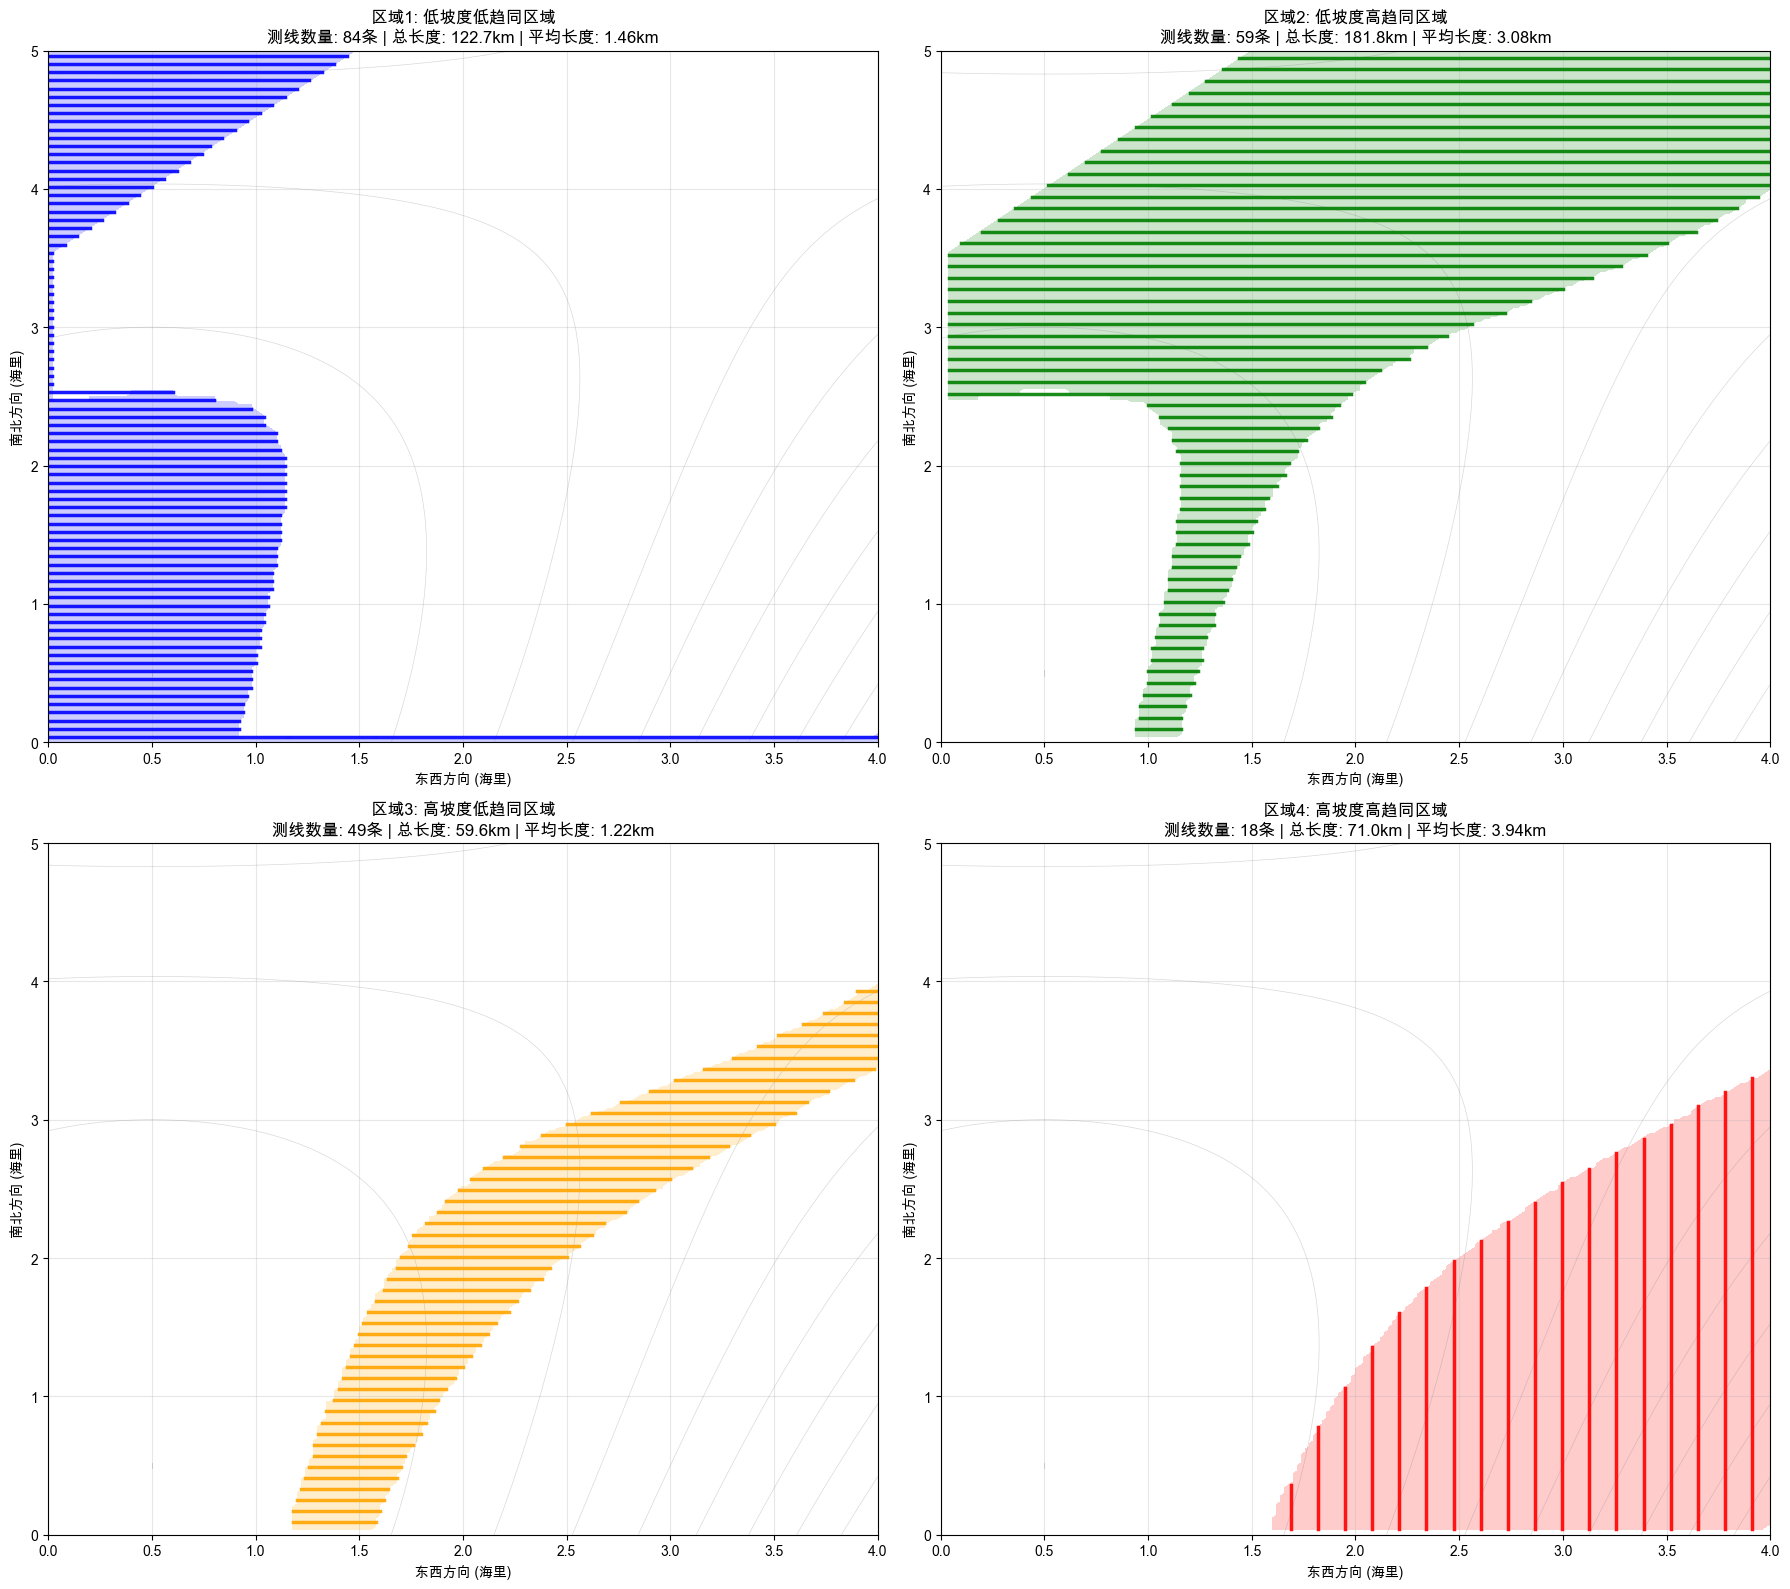

                        ÂêÑÂàÜÂå∫ÊµãÁ∫øËØ¶ÁªÜÂàÜÊûê

üè∑Ô∏è  Âå∫Âüü1: ‰ΩéÂù°Â∫¶‰ΩéË∂ãÂêåÂå∫Âüü:
   ÂàÜÂå∫Èù¢ÁßØÂç†ÊØî: 19.8%
   ËøûÈÄöÂ≠êÂå∫ÂüüÊï∞: 1‰∏™
   ÊµãÁ∫øÊÄªÊï∞: 84Êù°
   ÊÄªÊµãÁ∫øÈïøÂ∫¶: 122.68km
   Âπ≥ÂùáÊµãÁ∫øÈïøÂ∫¶: 1.46km
   Âπ≥ÂùáË¶ÜÁõñÂÆΩÂ∫¶: 0.075Êµ∑Èáå
   ÊñπÂêë‰∏ÄËá¥ÊÄß: 0.198
   ‰∏ªË¶ÅÊµãÁ∫øÊñπÂêë: ‰∏úË•øÂêë (180.1¬∞)
   ÊµãÁ∫øÈïøÂ∫¶ËåÉÂõ¥: 0.04km - 7.41km
   ÊµãÁ∫øÈïøÂ∫¶Ê†áÂáÜÂ∑Æ: 1.06km

üè∑Ô∏è  Âå∫Âüü2: ‰ΩéÂù°Â∫¶È´òË∂ãÂêåÂå∫Âüü:
   ÂàÜÂå∫Èù¢ÁßØÂç†ÊØî: 41.3%
   ËøûÈÄöÂ≠êÂå∫ÂüüÊï∞: 1‰∏™
   ÊµãÁ∫øÊÄªÊï∞: 59Êù°
   ÊÄªÊµãÁ∫øÈïøÂ∫¶: 181.76km
   Âπ≥ÂùáÊµãÁ∫øÈïøÂ∫¶: 3.08km
   Âπ≥ÂùáË¶ÜÁõñÂÆΩÂ∫¶: 0.106Êµ∑Èáå
   ÊñπÂêë‰∏ÄËá¥ÊÄß: 0.274
   ‰∏ªË¶ÅÊµãÁ∫øÊñπÂêë: ‰∏úË•øÂêë (194.9¬∞)
   ÊµãÁ∫øÈïøÂ∫¶ËåÉÂõ¥: 0.37km - 6.48km
   ÊµãÁ∫øÈïøÂ∫¶Ê†áÂáÜÂ∑Æ: 2.43km

üè∑Ô∏è  Âå∫Âüü3: È´òÂù°Â∫¶‰ΩéË∂ãÂêåÂå∫Âüü:
   ÂàÜÂå∫Èù¢ÁßØÂç†ÊØî: 13.2%
   ËøûÈÄöÂ≠êÂå∫ÂüüÊï∞: 1‰∏™
   ÊµãÁ∫øÊÄªÊï∞: 49Êù°
   ÊÄªÊµãÁ∫øÈïøÂ∫¶: 59.60km
   Âπ≥ÂùáÊµãÁ∫øÈïøÂ∫¶: 1.22km
   Âπ≥ÂùáË¶ÜÁõñÂÆΩÂ∫¶: 0.102Êµ∑Èáå
   ÊñπÂêë‰

In [81]:
# 15. ÂêÑ‰∏™Âå∫ÂüüÊµãÁ∫øÂçïÁã¨Â±ïÁ§∫

fig, axes = plt.subplots(2, 2, figsize=(18, 16))
colors = ['blue', 'green', 'orange', 'red']
zone_names = ['Âå∫Âüü1: ‰ΩéÂù°Â∫¶‰ΩéË∂ãÂêåÂå∫Âüü', 'Âå∫Âüü2: ‰ΩéÂù°Â∫¶È´òË∂ãÂêåÂå∫Âüü', 
              'Âå∫Âüü3: È´òÂù°Â∫¶‰ΩéË∂ãÂêåÂå∫Âüü', 'Âå∫Âüü4: È´òÂù°Â∫¶È´òË∂ãÂêåÂå∫Âüü']

for idx, zone_id in enumerate(range(1, 5)):
    row = idx // 2
    col = idx % 2
    ax = axes[row, col]
    
    # Ëé∑ÂèñÂΩìÂâçÂàÜÂå∫ÁöÑmask
    zone_mask = (zones == zone_id)
    
    # ÊòæÁ§∫ÂàÜÂå∫ËÉåÊôØ
    zone_background = np.where(zone_mask, zone_id, np.nan)
    im = ax.contourf(X, Y, zone_background, levels=[zone_id-0.5, zone_id+0.5], 
                     colors=[colors[zone_id-1]], alpha=0.2)
    
    # Âè†Âä†Á≠âÊ∑±Á∫ø
    ax.contour(X, Y, depth_data, levels=np.arange(20, 200, 20), 
               colors='gray', alpha=0.3, linewidths=0.5)
    
    # ÁªòÂà∂ËØ•ÂàÜÂå∫ÁöÑÊµãÁ∫ø
    if zone_id in zone_survey_plans and 'survey_lines' in zone_survey_plans[zone_id]:
        plan = zone_survey_plans[zone_id]
        line_count = 0
        
        for line in plan['survey_lines']:
            start_x, start_y = line['start']
            end_x, end_y = line['end']
            
            # È™åËØÅÊµãÁ∫øÂú®ÂàÜÂå∫ÂÜÖ
            start_x_idx = np.argmin(np.abs(x_coords - start_x))
            start_y_idx = np.argmin(np.abs(y_coords - start_y))
            end_x_idx = np.argmin(np.abs(x_coords - end_x))
            end_y_idx = np.argmin(np.abs(y_coords - end_y))
            
            if (zone_mask[start_y_idx, start_x_idx] and zone_mask[end_y_idx, end_x_idx]):
                ax.plot([start_x, end_x], [start_y, end_y], 
                       color=colors[zone_id-1], linewidth=2.5, alpha=0.9)
                line_count += 1
        
        # Ê∑ªÂä†ÁªüËÆ°‰ø°ÊÅØ
        total_length = plan['total_length'] / 1000  # ËΩ¨Êç¢‰∏∫km
        avg_length = total_length / plan['n_lines'] if plan['n_lines'] > 0 else 0
        
        # ËÆæÁΩÆÊ†áÈ¢òÂíåÁªüËÆ°‰ø°ÊÅØ
        ax.set_title(f'{zone_names[zone_id-1]}\n'
                    f'ÊµãÁ∫øÊï∞Èáè: {line_count}Êù° | ÊÄªÈïøÂ∫¶: {total_length:.1f}km | '
                    f'Âπ≥ÂùáÈïøÂ∫¶: {avg_length:.2f}km', 
                    fontsize=12, fontweight='bold')
    else:
        ax.set_title(f'{zone_names[zone_id-1]}\nÊó†ÊµãÁ∫øÊï∞ÊçÆ', 
                    fontsize=12, fontweight='bold')
    
    # ËÆæÁΩÆËΩ¥Ê†áÁ≠æÂíåÁΩëÊ†º
    ax.set_xlabel('‰∏úË•øÊñπÂêë (Êµ∑Èáå)', fontsize=10)
    ax.set_ylabel('ÂçóÂåóÊñπÂêë (Êµ∑Èáå)', fontsize=10)
    ax.grid(True, alpha=0.3)
    
    # ËÆæÁΩÆÁõ∏ÂêåÁöÑÂùêÊ†áËåÉÂõ¥‰ª•‰æøÊØîËæÉ
    ax.set_xlim(x_coords.min(), x_coords.max())
    ax.set_ylim(y_coords.min(), y_coords.max())

plt.tight_layout()
plt.show()

# ËæìÂá∫ÂêÑÂàÜÂå∫ËØ¶ÁªÜÁªüËÆ°
print("=" * 80)
print("                        ÂêÑÂàÜÂå∫ÊµãÁ∫øËØ¶ÁªÜÂàÜÊûê")
print("=" * 80)

for zone_id in range(1, 5):
    if zone_id in zone_survey_plans:
        plan = zone_survey_plans[zone_id]
        zone_mask = (zones == zone_id)
        zone_area = np.sum(zone_mask)
        
        print(f"\nüè∑Ô∏è  {zone_names[zone_id-1]}:")
        print(f"   ÂàÜÂå∫Èù¢ÁßØÂç†ÊØî: {zone_area/np.sum(~np.isnan(zones))*100:.1f}%")
        print(f"   ËøûÈÄöÂ≠êÂå∫ÂüüÊï∞: {plan['n_segments']}‰∏™")
        print(f"   ÊµãÁ∫øÊÄªÊï∞: {plan['n_lines']}Êù°")
        print(f"   ÊÄªÊµãÁ∫øÈïøÂ∫¶: {plan['total_length']/1000:.2f}km")
        print(f"   Âπ≥ÂùáÊµãÁ∫øÈïøÂ∫¶: {plan['total_length']/plan['n_lines']/1000:.2f}km")
        print(f"   Âπ≥ÂùáË¶ÜÁõñÂÆΩÂ∫¶: {plan['avg_coverage_width']:.3f}Êµ∑Èáå")
        print(f"   ÊñπÂêë‰∏ÄËá¥ÊÄß: {plan['direction_consistency']:.3f}")
        
        # ÂàÜÊûêÊµãÁ∫øÊñπÂêë
        if len(plan['survey_lines']) > 0:
            first_line = plan['survey_lines'][0]
            direction_deg = np.degrees(first_line['direction']) % 360
            if abs(first_line['start'][0] - first_line['end'][0]) > abs(first_line['start'][1] - first_line['end'][1]):
                main_direction = "‰∏úË•øÂêë"
            else:
                main_direction = "ÂçóÂåóÂêë"
            
            print(f"   ‰∏ªË¶ÅÊµãÁ∫øÊñπÂêë: {main_direction} ({direction_deg:.1f}¬∞)")
        
        # ÊµãÁ∫øÈïøÂ∫¶ÂàÜÂ∏É
        lengths = [line['length']/1000 for line in plan['survey_lines']]
        if lengths:
            print(f"   ÊµãÁ∫øÈïøÂ∫¶ËåÉÂõ¥: {min(lengths):.2f}km - {max(lengths):.2f}km")
            print(f"   ÊµãÁ∫øÈïøÂ∫¶Ê†áÂáÜÂ∑Æ: {np.std(lengths):.2f}km")

print(f"\n{'='*80}")
print("üéØ ÂàÜÂå∫ÊµãÁ∫øËÆæËÆ°Á≠ñÁï•È™åËØÅ:")
for zone_id in range(1, 5):
    strategy = zone_strategies[zone_id]['strategy']
    expected = zone_strategies[zone_id]['reason']
    print(f"   Âå∫Âüü{zone_id}: {strategy} - {expected}")

print(f"\nüìä ÊÄª‰Ωì‰ºòÂåñÊïàÊûú:")
print(f"   ‚úì ÊÄªÊµãÁ∫øÈïøÂ∫¶: {total_survey_length/1000:.2f}km")
print(f"   ‚úì Êµ∑ÂüüË¶ÜÁõñÁéá: {metrics['coverage_percentage']:.1f}%")
print(f"   ‚úì ÈáçÂè†ÊéßÂà∂: {metrics['overlap_percentage']:.1f}%")
print(f"   ‚úì ÂàÜÂå∫Á∫¶Êùü: ‰∏•Ê†ºÊª°Ë∂≥ÔºåÊØè‰∏™Âå∫ÂüüÊµãÁ∫øÁã¨Á´ã")
print("=" * 80)